## Imports, Smurf Control Class, and Versions

In [14]:
import glob 
import numpy as np
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pylab as plt
import datetime
from scipy.signal import butter, welch, filtfilt, periodogram, savgol_filter
import time
import pandas as pd
import sys
import os
import re


In [2]:
pip install h5py

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pysmurf.client
import matplotlib.pylab as plt
%matplotlib inline  

epics_prefix="smurf_server_s4"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg")
## going to run setup just this time
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=True,shelf_manager="shm-smrf-sp01")
logfile = S.log.logfile.name

ChannelAccessGetFailure: Get failed; status code: 152

CA.Client.Exception...............................................
    Context: "localhost:5064"
    Source File: ../cac.cpp line 1223
    Current Time: Mon Aug 26 2024 15:52:27.758594344
..................................................................


In [14]:
print(logfile)

/data/smurf_data/20240823/1724428883/outputs/1724428883.log


In [15]:
print(logfile)
print('Pysmurf Client Version:',pysmurf.__version__)
epics_prefix=f'smurf_server_s{S.slot_number}'
print('Rogue Version:',S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True))
print('Pysmurf Core Version:', S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True))
print('FPGA Git Hash Short:', S.get_fpga_git_hash_short())
print('Config file:', S.config.filename)
print('Cryocard FW Version:', S.C.get_fw_version())

Pysmurf Client Version: 8.0.0-rc3
Rogue Version: v4.11.11
Pysmurf Core Version: 8.0.0-rc3
FPGA Git Hash Short: 02ed52a
Config file: /usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg
Cryocard FW Version: (0, 0, 0)


In [16]:
os.chdir('/usr/local/src/pysmurf/scratch/smithzj/')
print(os.getcwd())
from ResonanceFitter import *

/usr/local/src/pysmurf/scratch/smithzj


## General "through the fridge" system checkk 

In [17]:
print(S.get_att_uc(2))
S.set_att_uc(2, 0)
print(S.get_att_uc(2))

0
0


-------------------------------------------------------
Estimated cable_delay_us=0.7341747051717614
Estimated dsp_delay_us=8.890073728309401
Estimated processing_delay_us=8.15589902313764
-------------------------------------------------------


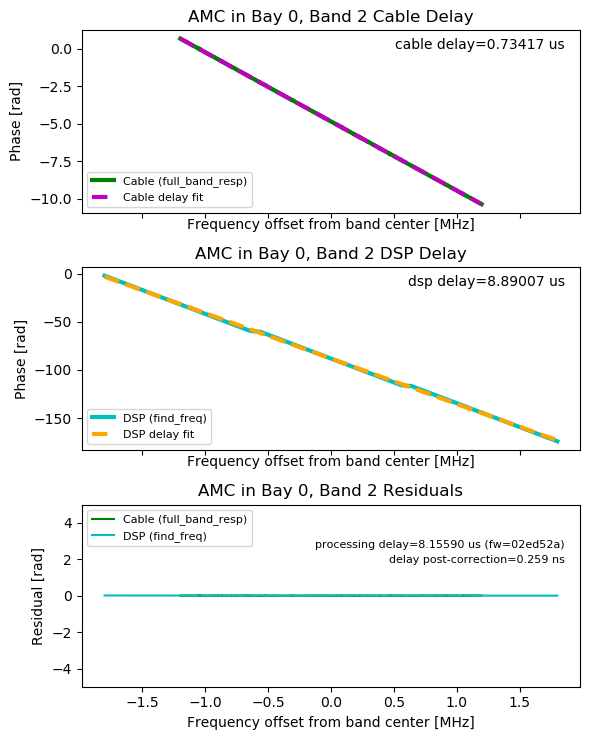

(8.890073728309401, 0.00025880142622850005)

In [19]:
print(S.get_att_uc(2))
S.set_att_uc(2, 0)
print(S.get_att_uc(2))
S.estimate_phase_delay(2,freq_min=-1200000,freq_max=1200000)

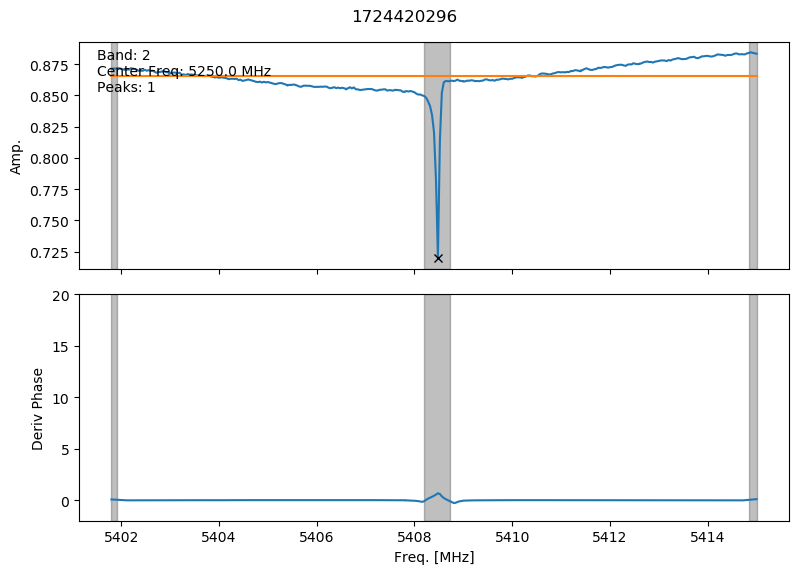

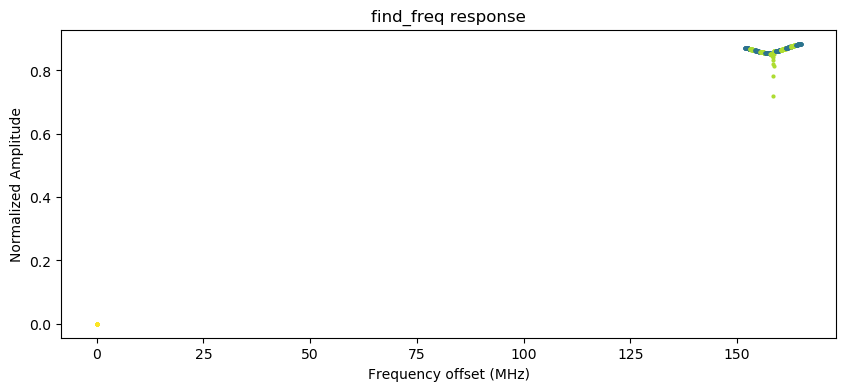

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [8]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

### Just going to check that we get pulses on LED

In [12]:
S.which_on(2)

array([], dtype=int64)

In [13]:
S.setup_notches(2,new_master_assignment=True)

In [14]:
S.set_feedback_enable_channel(2,66,0)

In [15]:
S.which_on(2)

array([66])

In [16]:
band=2
channel=66
nsamp=2**10
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)    

In [17]:
print(i)

[0.46634946 0.47322121 0.47693768 ... 0.47529244 0.46915598 0.46727428]


In [55]:
#S.set_feedback_enable(2, 0)

Signature: S.set_feedback_enable(band, val, **kwargs)
Docstring:         
Source:   
    def set_feedback_enable(self, band, val, **kwargs):
        """
        """
        self._caput(
            self._band_root(band) + self._feedback_enable_reg,
            val, **kwargs)
File:      /usr/local/src/pysmurf/python/pysmurf/client/command/smurf_command.py
Type:      method

In [21]:
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone

In [43]:
band=2
channel=66
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 3
nsamp = int(n_cycles * time_per_cycle / time_per_sample)
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)    

In [44]:
print(i)

[0.56185684 0.55893245 0.55831847 ... 0.56166229 0.56083088 0.55720224]


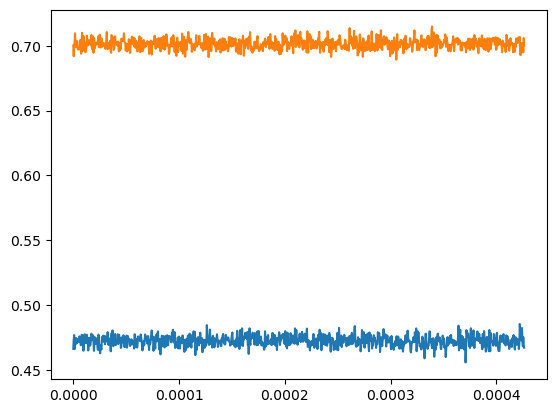

In [18]:
plt.plot(np.arange(len(i))/(2.4e6), i)
plt.plot(np.arange(len(i))/(2.4e6), q)

In [50]:
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 3
samples = n_cycles * time_per_cycle / time_per_sample
print(samples)

72000.0


In [49]:
print(time_per_cycle * n_cycles)

0.03


In [56]:
S.which_on(2)

array([66])

In [ ]:
set current to max 

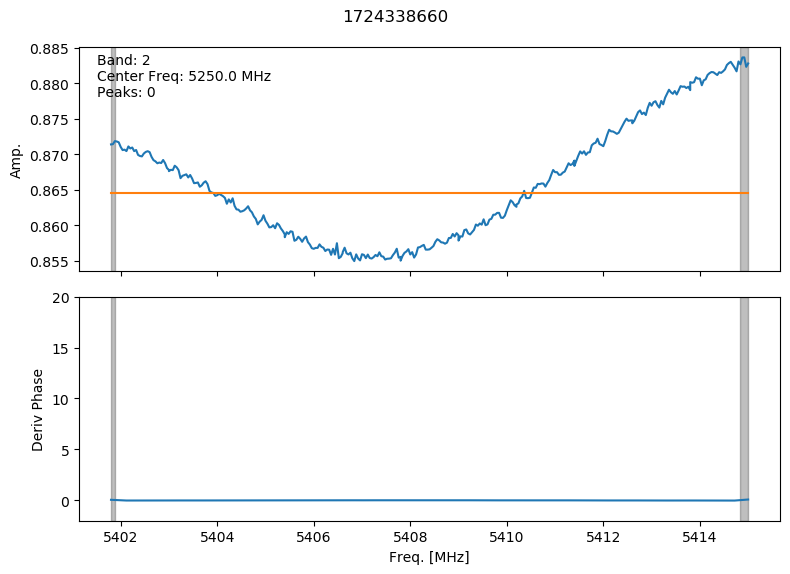

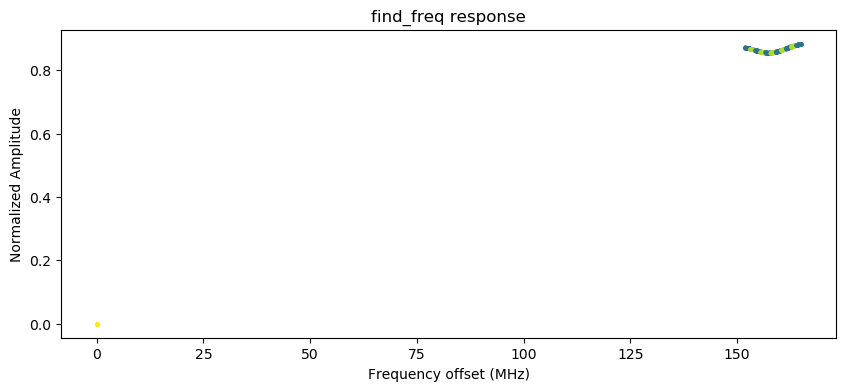

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [57]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

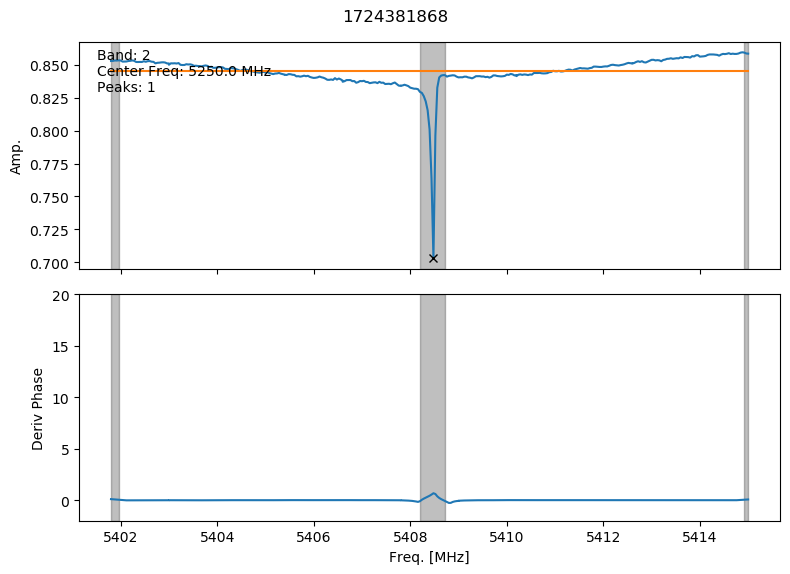

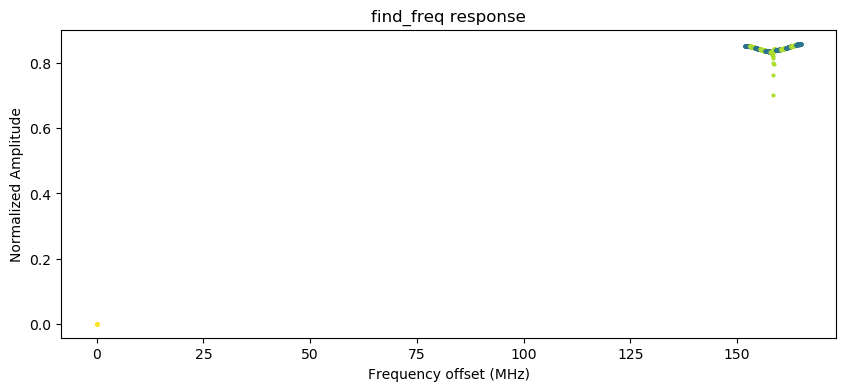

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [146]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

In [148]:
S.get_feedback_enable_channel(2,16)


0

In [149]:
S.setup_notches(2,new_master_assignment=True)

10.922666666666666


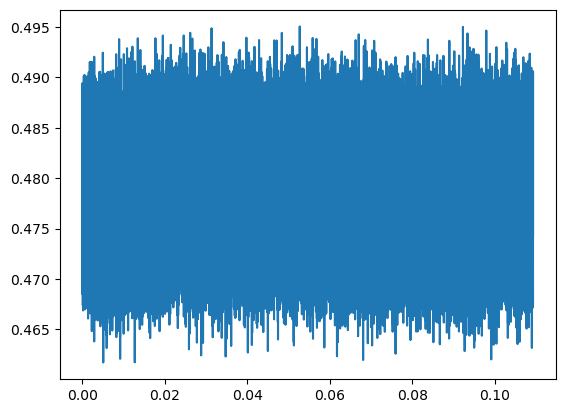

In [158]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18 # int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [31]:
# S.get_amplitude_scale_channel(2,66)
S.set_amplitude_scale_channel(2, 66, 12)
S.get_amplitude_scale_channel(2,66)

12

In [32]:
S.check_adc_saturation(2)

False

10.922666666666666


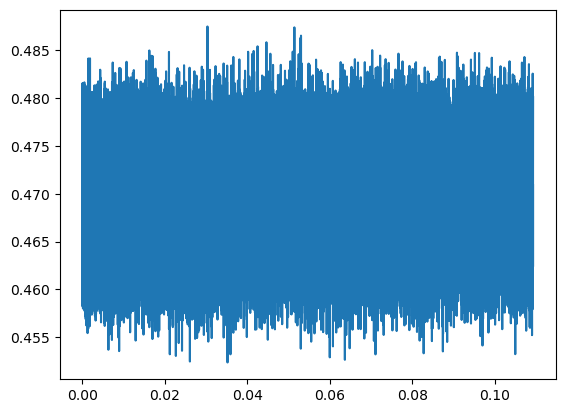

In [35]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [30]:
S._caget(f'{S.app_core}modeStream')

0

10.922666666666666


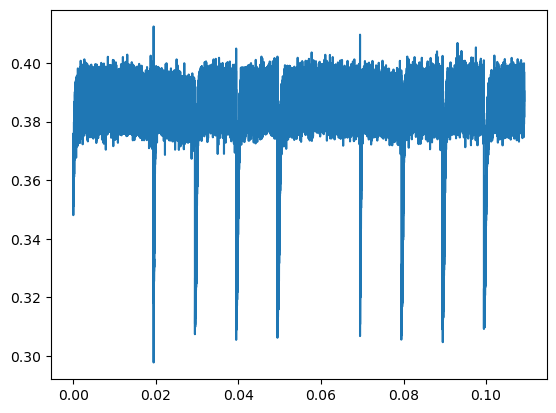

In [96]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [86]:
nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))

10.922666666666666


In [150]:
S.get_feedback_enable_channel(2,66)

1

In [151]:
S.set_feedback_enable_channel(2,66,0)

In [152]:
S.get_feedback_enable_channel(2,66)

0

## going to take some real data now: 

In [99]:
splendaq_moku_file = 'modulated_square_wave_amps_0p0_0p25_0p5_0p75_1p0.csv'
splendaq_moku_Vpp = 10 #V
splendaq_moku_period_ms = 50 
splendaq_moku_samp_rate = 312.5*1e6

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**25 # int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
#plt.plot(time, i)

1398.1013333333333


Text(0, 0.5, 'i')

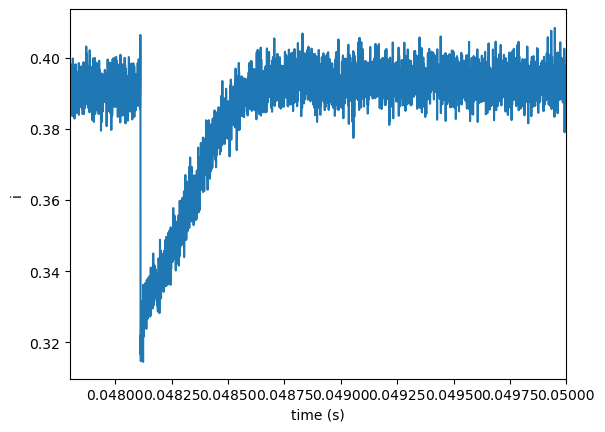

In [119]:
start = int(6000 + 4* time_per_cycle / time_per_sample)
stop = int(start + time_per_cycle / time_per_sample)
plt.plot(time[start:stop], i[start:stop])
plt.xlim(0.0478, 0.05)
plt.xlabel("time (s)")
plt.ylabel("i")

In [122]:
channel_freq = S.get_channel_frequency_mhz(2) * 1.0E6
print(channel_freq/1e6)

2.4


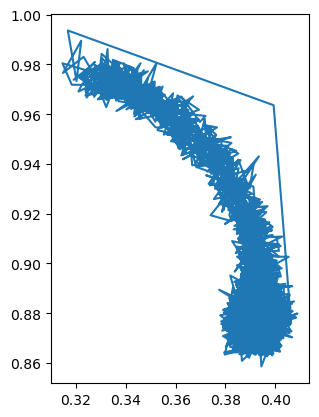

In [124]:
plt.plot(i[start:stop], q[start:stop])
plt.gca().set_aspect("equal")

In [125]:
S.which_on(2)

array([66])

In [126]:
S.channel_off(2, 66)

In [24]:
def chunk_data(fs_MHz, chunk_duration_us, data,  start=0):
    """
    fs_MHz: sample freq, MHz
    chunk_duration_us: period of wave on LED 
    data: np array with shape: (n_samp,) data to chunk up 
    start: idx to start your chunks on, so you can center pulses in the window 
    returns: raw data, separated into chunks. 
    """
    n_samp = len(data)
    # Calculate the number of samples per chunk
    samples_per_chunk = int(fs_MHz * chunk_duration_us)
    num_chunks = n_samp // samples_per_chunk 
    if start != 0:
        num_chunks -= 1
    #remove the end of the data, so you can have divisible chunks
    data_chunks = data[start:num_chunks*samples_per_chunk+start]

    # Reshape the array into chunks
    data_chunks = data_chunks.reshape(num_chunks, (samples_per_chunk))

    return data_chunks 
    
def getBigIdx(iq_chunks, num_pulses):
    maxs = np.max(np.abs(iq_chunks.real[0:num_pulses]), axis = 1)
    big_idx= np.argmax(maxs)
    return big_idx


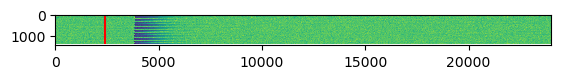

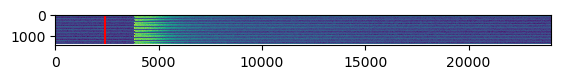

In [145]:

iq = i + 1j*q

iq_chunks = chunk_data(2.4 , 10000, iq, start=0) # this has a pulse starting in a random location
chunk_len = len(iq_chunks[0])

## Find the window which has the highest amplitude pulse. In this case looking at imaginary (Q) data
bigIdx = getBigIdx(iq_chunks, 5)

## Get start of data -> end of whole data collection
iq_start_big  = iq[chunk_len*bigIdx:] 
## Gets index of the minimum in the pulse window (because this is where the pulse is -> the shape is a dip.
                
                
big_pulse_loc = np.argmin(iq_start_big[:chunk_len].real)


 ## this will skip over a window where the pulse happens too early and go to the next biggest pulse.
if big_pulse_loc - 2400 - 1*len(iq_chunks)-50< 0: 
    c_cuts = 5
    print("pre trigger too big in ", f)
    iq_start_big  = iq[int(chunk_len*(c_cuts+bigIdx)-2400-len(iq_chunks)-50): ]
else:
    c_cuts = 0
    iq_start_big  = iq[int(chunk_len*(c_cuts+bigIdx)): ]
## This finds the location of the pulse again (which will be the same if the pre trigger wasn't too big)
big_pulse_loc_2  = np.argmin(iq_start_big[:chunk_len].real)
## This finds the point (pre_trigger + len(iq_chunks) + buffer) before the trigger
iq_start_pre = iq_start_big[int(big_pulse_loc_2 - 2400-len(iq_chunks)-50): ]
##This chunks the data again, where the first chunk always starts (pre_trigger + len(iq_chunks) + buffer) before the pulse.
end_chunks =  chunk_data(2.4 , 10000, iq_start_pre, start=0)


plt.imshow(end_chunks.real)
plt.vlines(2400, 0, len(end_chunks), color='r') #*(1/fs_MHz)*1e-3
plt.show()
plt.imshow(end_chunks.imag)
plt.vlines(2400, 0, len(end_chunks), color='r') #*(1/fs_MHz)*1e-3
plt.show()


In [ ]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18 # int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [38]:
?S.stream_data_on
                

Signature:
S.stream_data_on(
    write_config=False,
    data_filename=None,
    downsample_factor=None,
    write_log=True,
    update_payload_size=True,
    reset_filter=True,
    reset_unwrapper=True,
    make_freq_mask=True,
    channel_mask=None,
    make_datafile=True,
    filter_wait_time=0.1,
)
Docstring:
Turns on streaming data.

Args
----
write_config : bool, optional, default False
    Whether to dump the entire config. Warning this can be
    slow.
data_filename : str or None, optional, default None
    The full path to store the data. If None, it uses the
    timestamp.
downsample_factor : int or None, optional, default None
    The number of fast samples to skip between sending.
write_log : bool, optional, default True
    Whether to write to the log file.
update_payload_size : bool, optional, default True
    Whether to update the payload size (the number of channels
    written to disk). If this is True, will set the payload size to
    0, which tells rogue to automatic

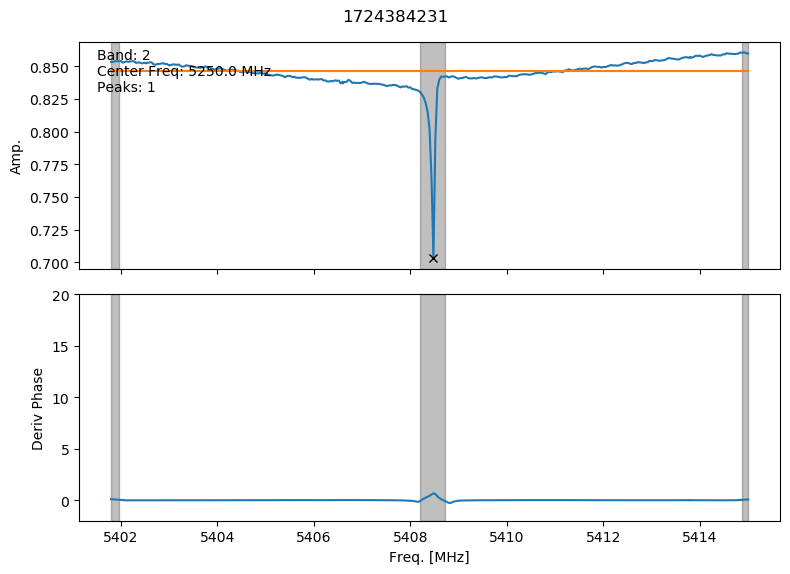

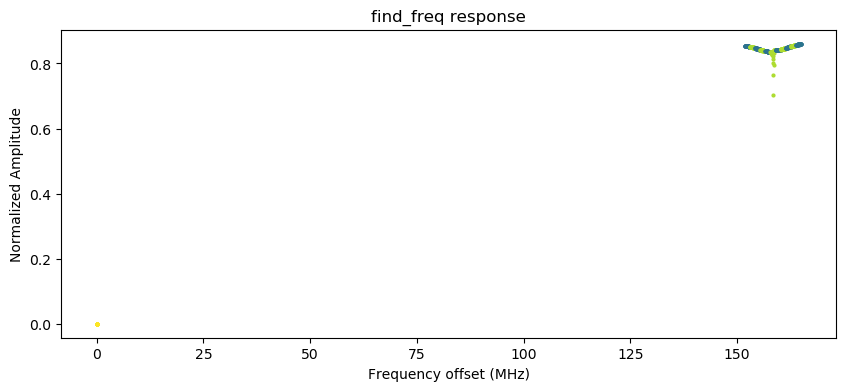

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [8]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

In [11]:
S.setup_notches(2,new_master_assignment=True)

In [12]:
S.set_feedback_enable_channel(2,66, 0)
S.set_channel

AttributeError: 'SmurfControl' object has no attribute 'set_channel'

10.922666666666666


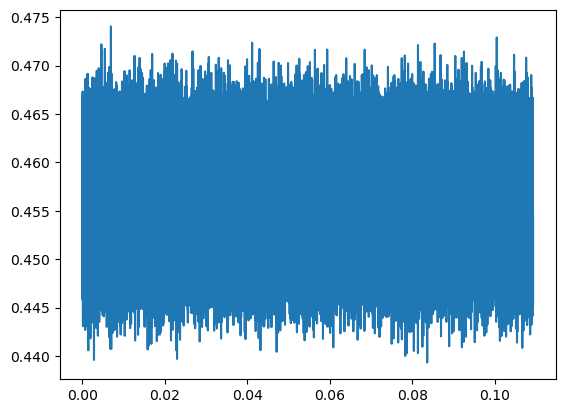

In [12]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [15]:
S.set_amplitude_scale_channel(2, 66, 12)
S.get_amplitude_scale_channel(2,66)

12

10.922666666666666


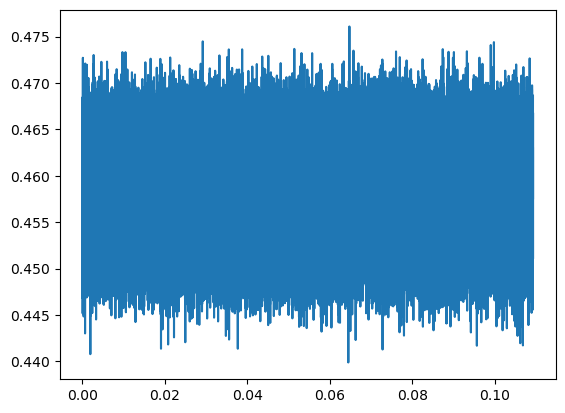

In [16]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

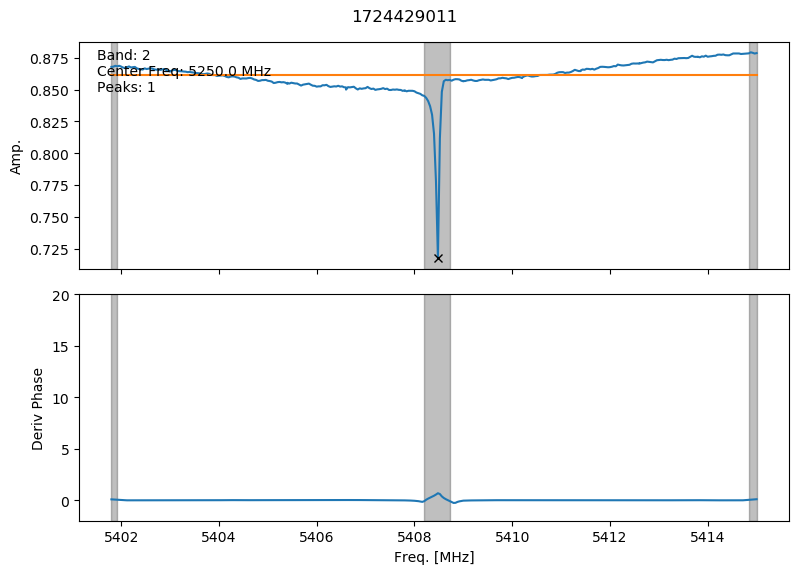

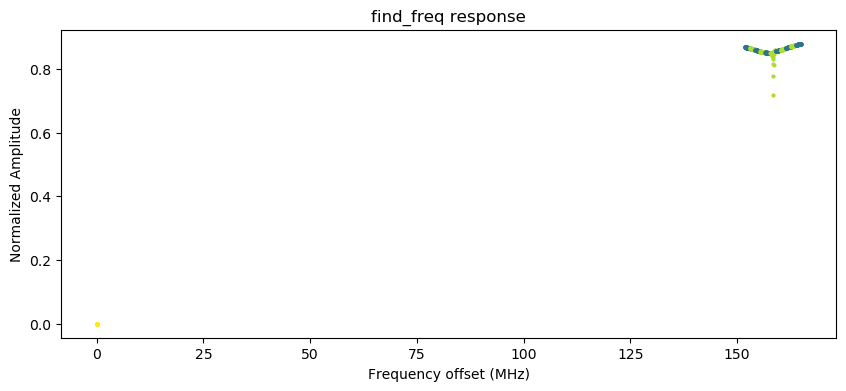

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [20]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

In [53]:
S.setup_notches(2,new_master_assignment=True)

In [54]:
S.set_feedback_enable_channel(2,66, 0)

10.922666666666666


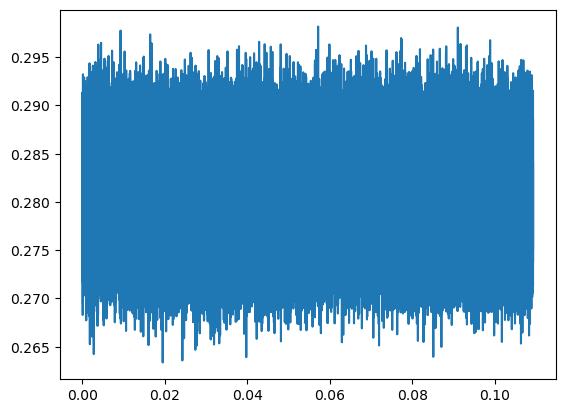

In [14]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

In [15]:
# S.set_amplitude_scale_channel(2, 66, 12)
S.get_amplitude_scale_channel(2,66)

12

10.922666666666666


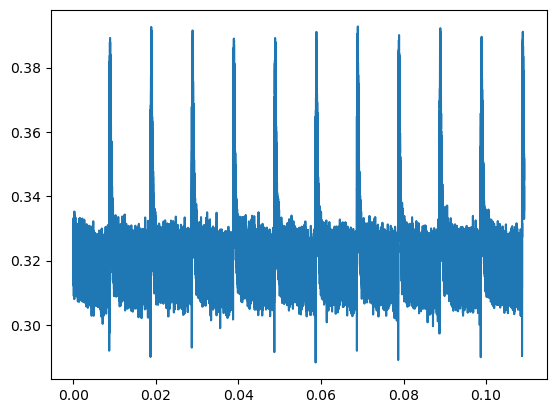

In [29]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

## Looking at 1 us pulses.

10.922666666666666


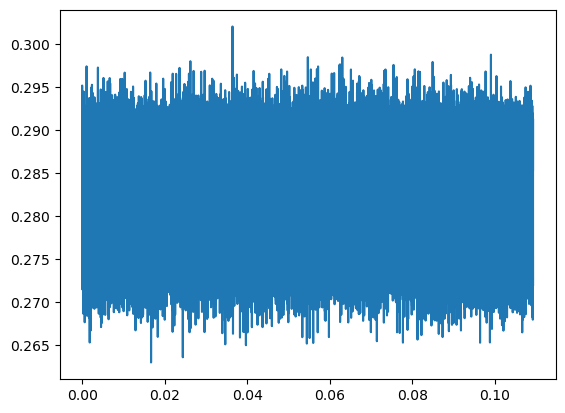

In [18]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

## Looking at 5 us pulses

10.922666666666666


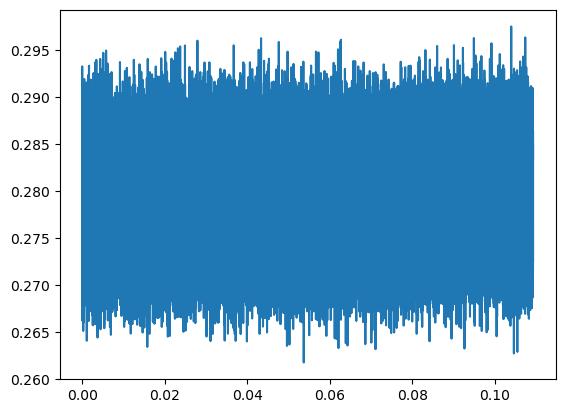

In [19]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

nsamp = 2**18# int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)

5.0


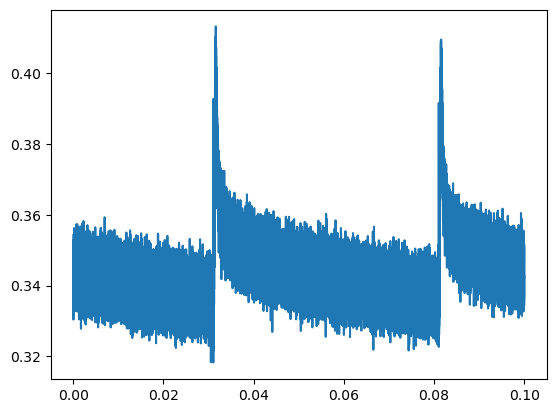

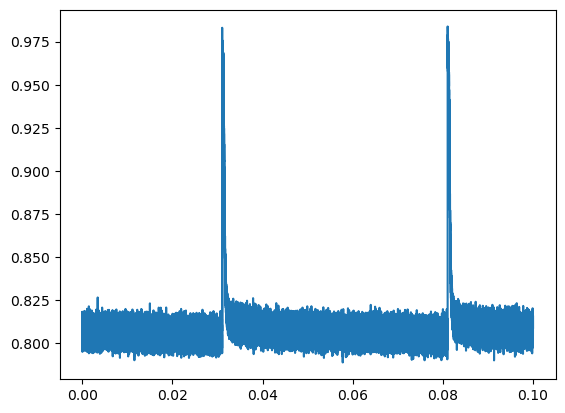

In [55]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.show()
plt.plot(time, q)


5.0


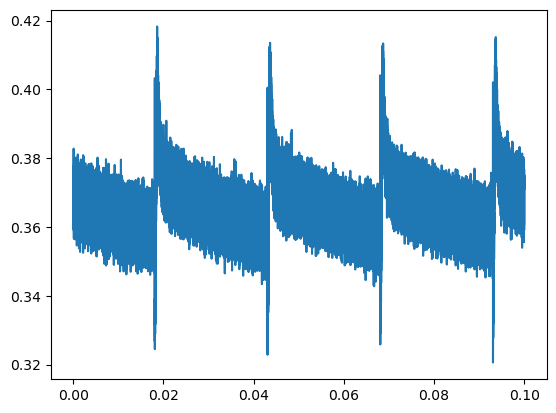

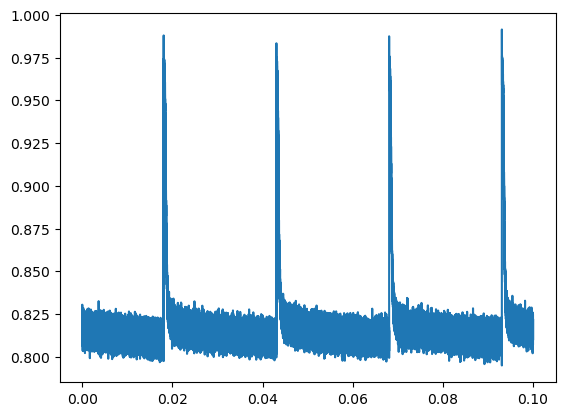

In [56]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.show()
plt.plot(time, q)


5.0


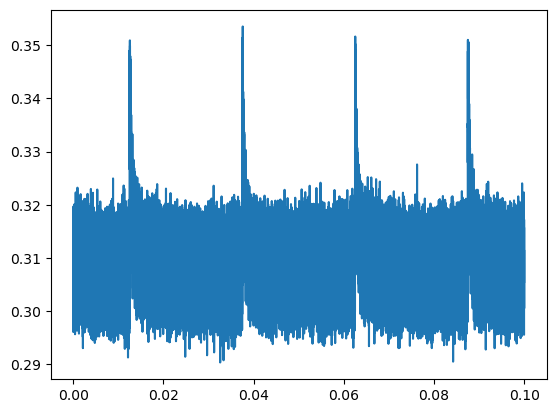

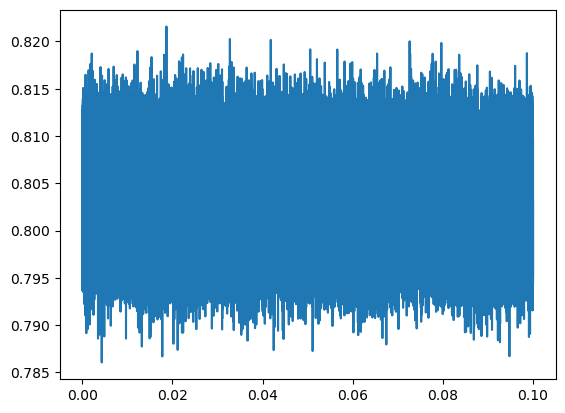

In [57]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.show()
plt.plot(time, q)


5.0


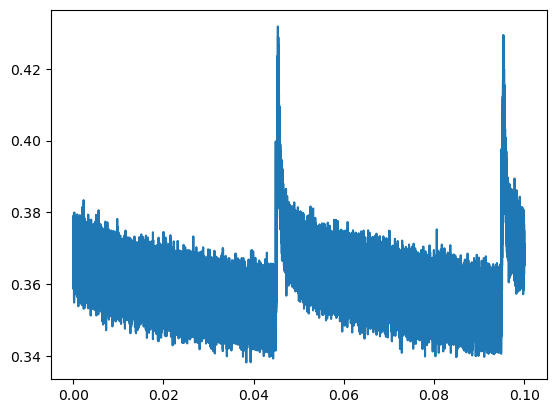

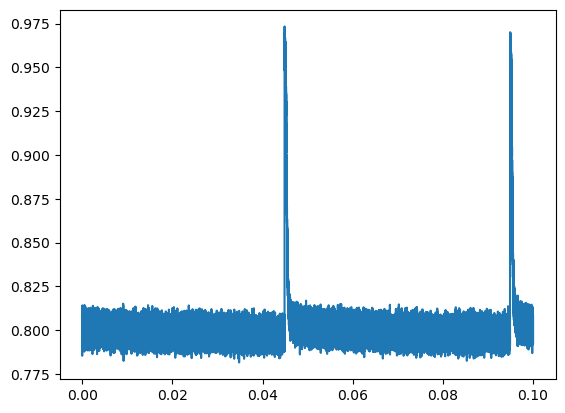

In [23]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)


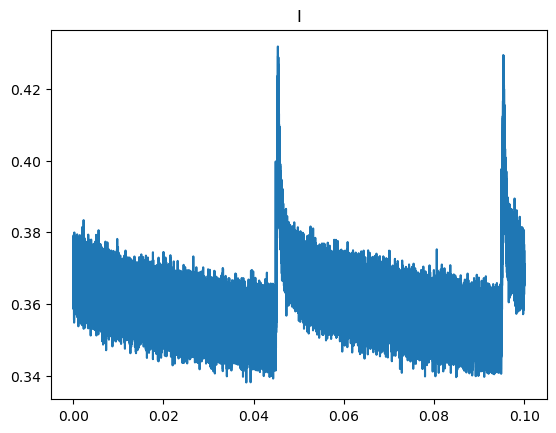

Text(0.5, 1.0, 'Q')

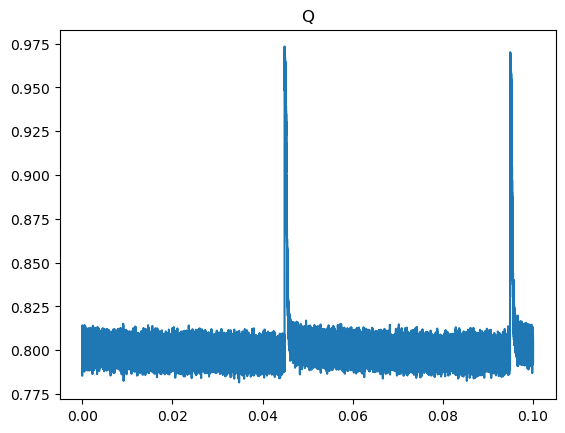

In [39]:
plt.plot(time, i)
plt.title("I")

# plt.ylim([.32, .37])
plt.show()
plt.plot(time, q)
plt.title("Q")

In [24]:
from KID_meas import *

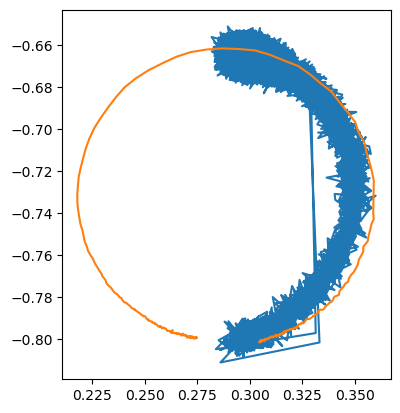

In [40]:
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

In [26]:
S.tune_file

'/data/smurf_data/tune/1724429031_tune.npy'

In [ ]:
## change from 4.75 to 4 Vpp

5.0


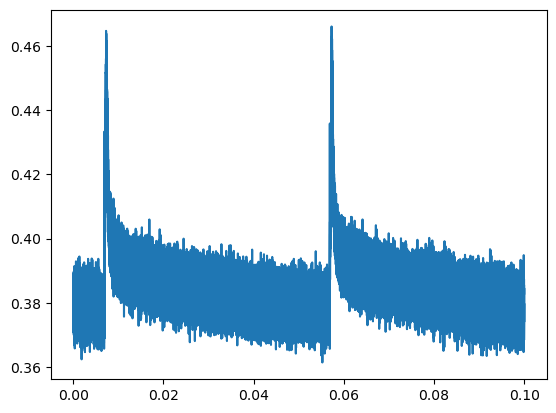

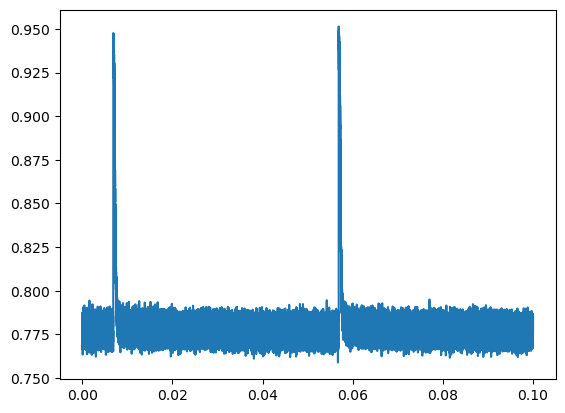

In [46]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)


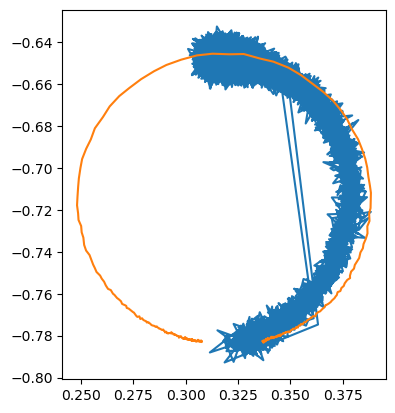

In [47]:
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

In [48]:
##change to 2.375 vpp

5.0


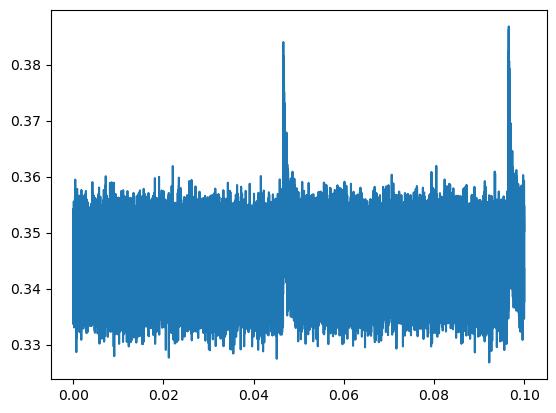

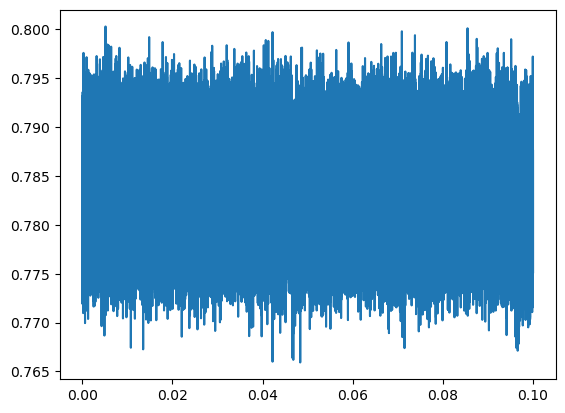

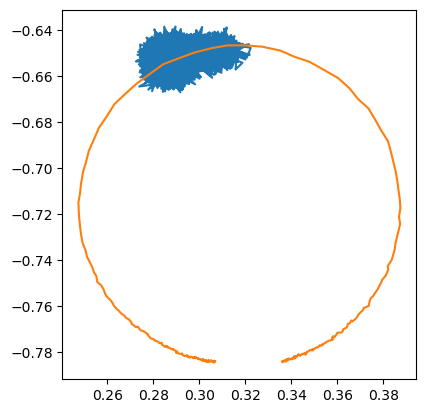

In [56]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

In [ ]:
##change to 3.5625

5.0


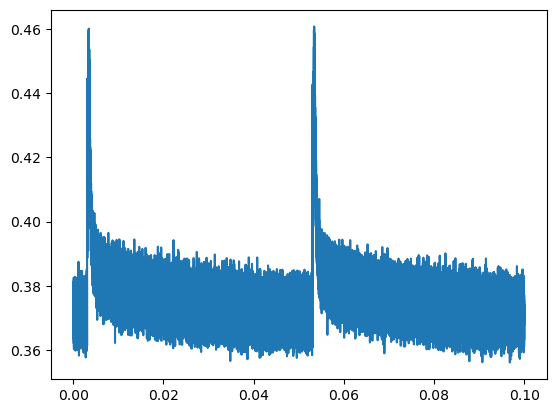

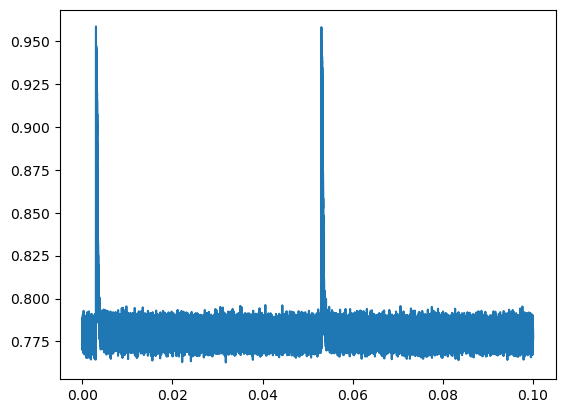

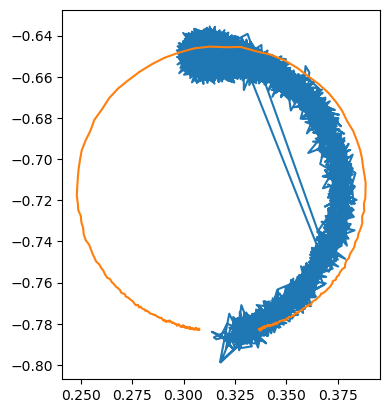

In [50]:
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

5.0


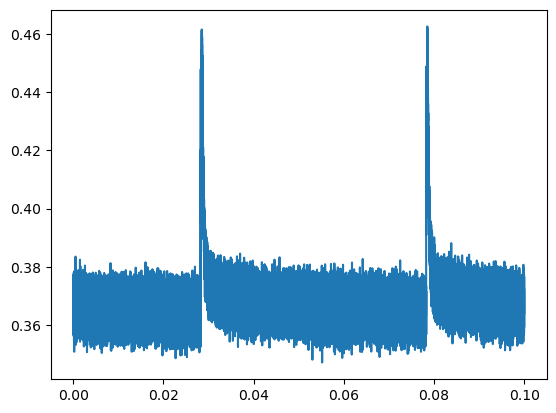

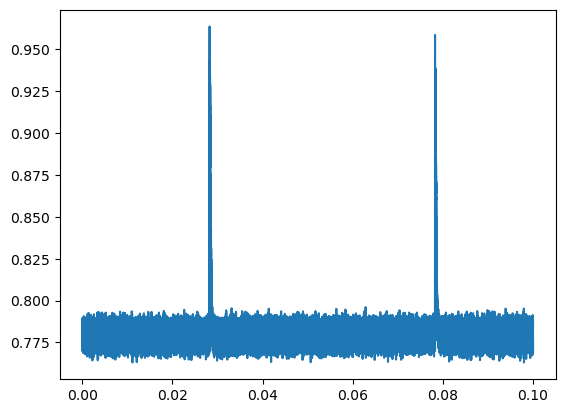

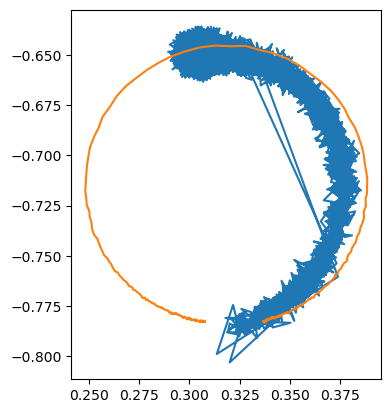

In [51]:
## 3 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

5.0


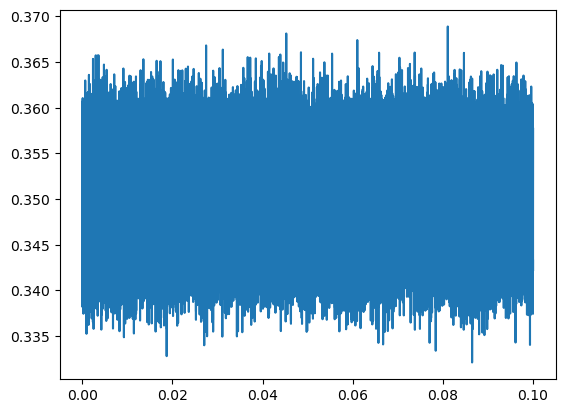

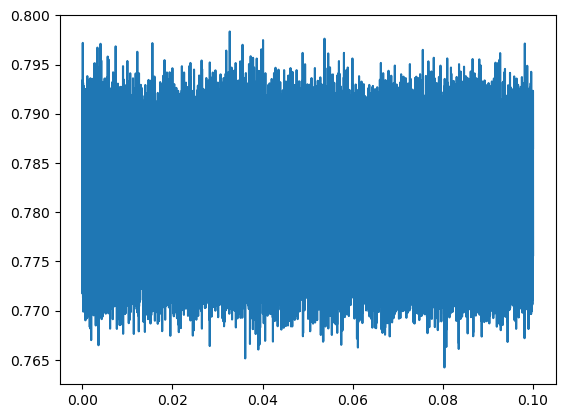

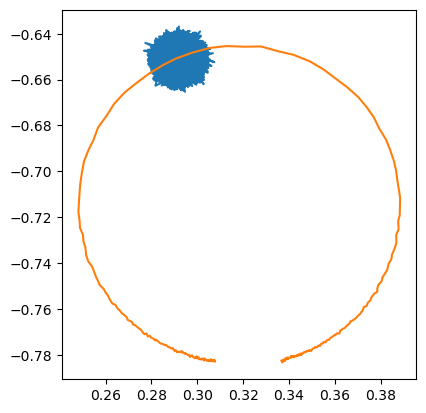

In [52]:
## 2 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

5.0


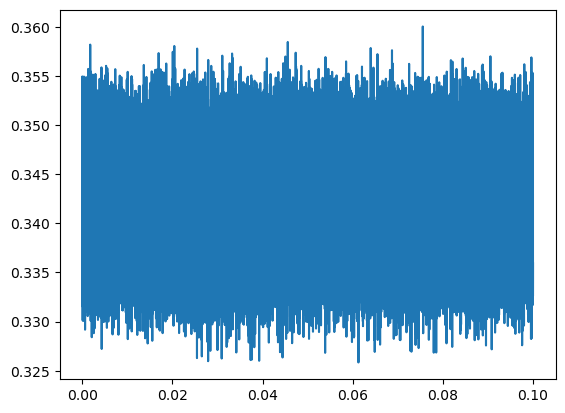

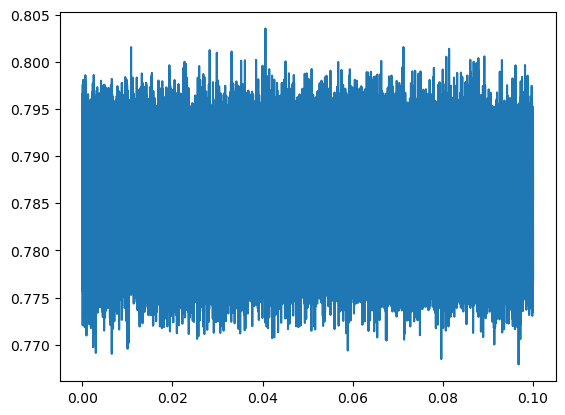

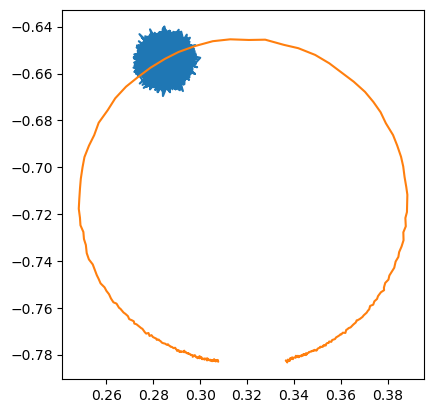

In [55]:
## 2 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

5.0


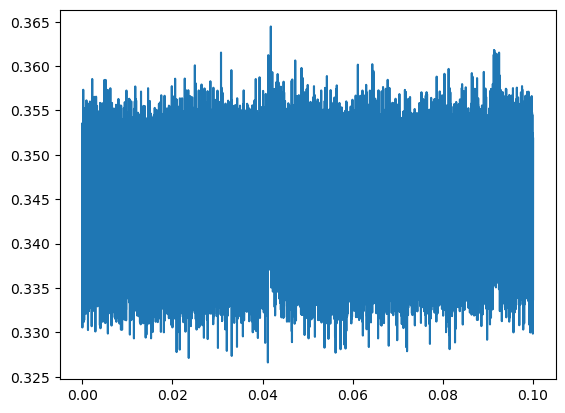

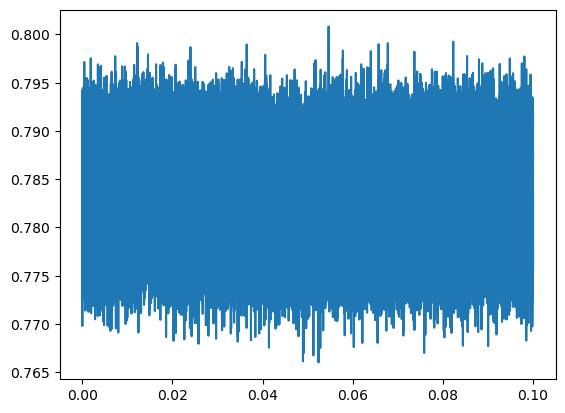

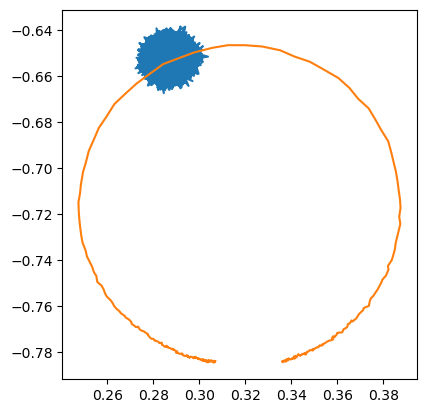

In [58]:
## 2.3 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

5.0


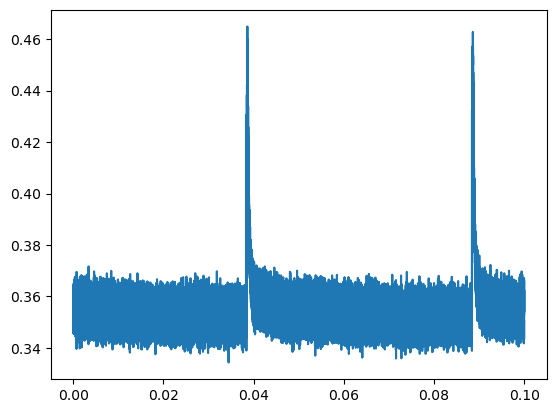

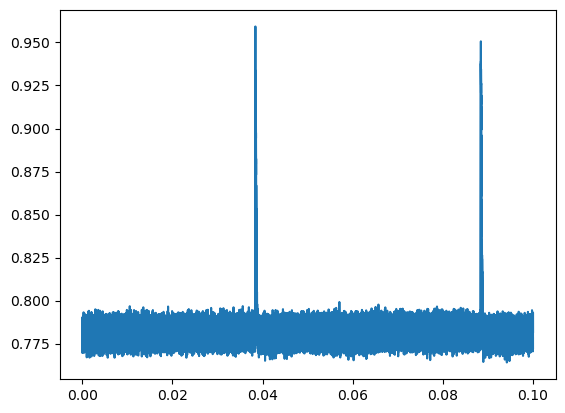

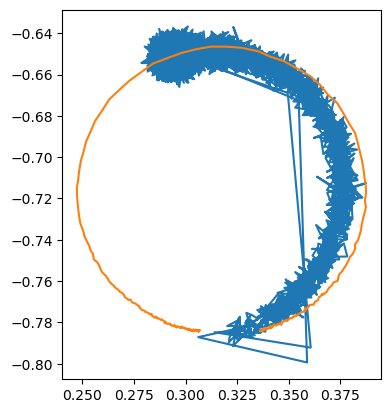

In [59]:
## 2.8 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 2/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

In [163]:
pip install h5py

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import glob 
import numpy as np
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pylab as plt
import datetime
from scipy.signal import butter, welch, filtfilt, periodogram, savgol_filter
import time
import pandas as pd
import sys
import os
import re


In [2]:
import pysmurf.client
import matplotlib.pylab as plt
%matplotlib inline  

epics_prefix="smurf_server_s4"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg")
## going to run setup just this time
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=True,shelf_manager="shm-smrf-sp01")
logfile = S.log.logfile.name

In [3]:
print(logfile)
print('Pysmurf Client Version:',pysmurf.__version__)
epics_prefix=f'smurf_server_s{S.slot_number}'
print('Rogue Version:',S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True))
print('Pysmurf Core Version:', S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True))
print('FPGA Git Hash Short:', S.get_fpga_git_hash_short())
print('Config file:', S.config.filename)
print('Cryocard FW Version:', S.C.get_fw_version())

/data/smurf_data/20240917/1726590761/outputs/1726590761.log
Pysmurf Client Version: 8.0.0-rc3
Rogue Version: v4.11.11
Pysmurf Core Version: 8.0.0-rc3
FPGA Git Hash Short: 5bdf96f
Config file: /usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg
Cryocard FW Version: (0, 0, 0)


In [4]:
os.chdir('/usr/local/src/pysmurf/scratch/smithzj/')
print(os.getcwd())
from ResonanceFitter import *

/usr/local/src/pysmurf/scratch/smithzj
/usr/local/src/pysmurf/scratch/smithzj


0
0
-------------------------------------------------------
Estimated cable_delay_us=0.7341460974706536
Estimated dsp_delay_us=8.888461086419383
Estimated processing_delay_us=8.15431498894873
-------------------------------------------------------


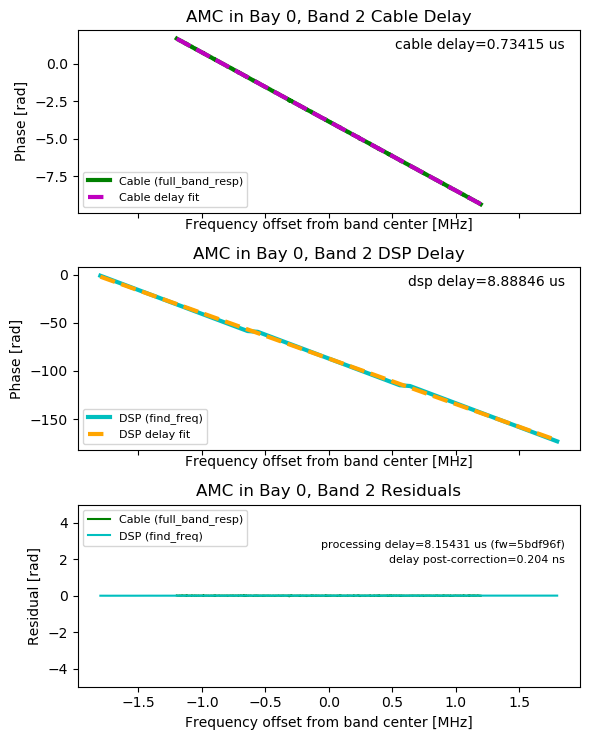

(8.888461086419383, 0.0002035759469436368)

In [5]:
print(S.get_att_uc(2))
S.set_att_uc(2, 0)
print(S.get_att_uc(2))
S.estimate_phase_delay(2,freq_min=-1200000,freq_max=1200000)

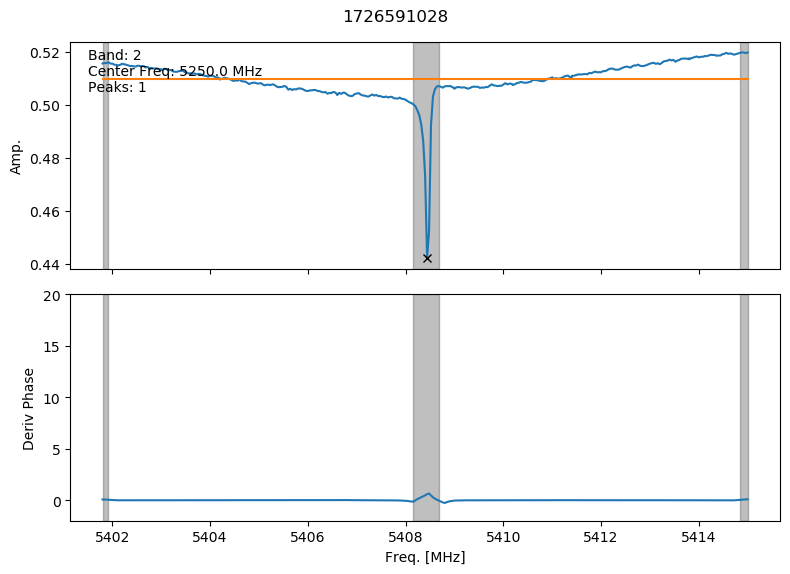

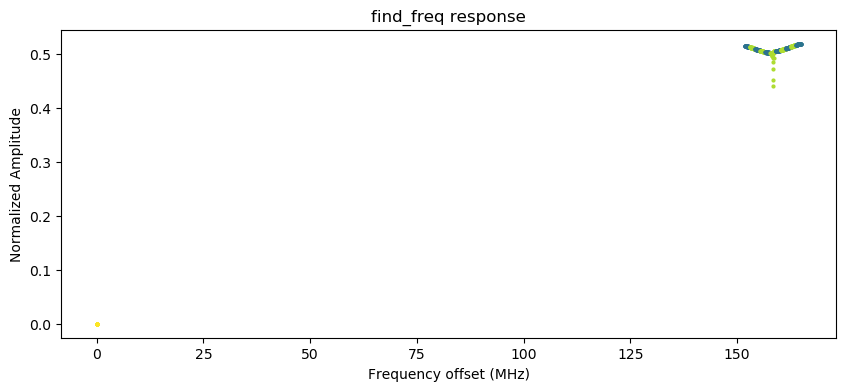

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [6]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

In [7]:
S.setup_notches(2,new_master_assignment=True)

In [8]:
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone

In [9]:
from KID_meas import *

In [14]:
S.which_on(2)

array([66])

5.0


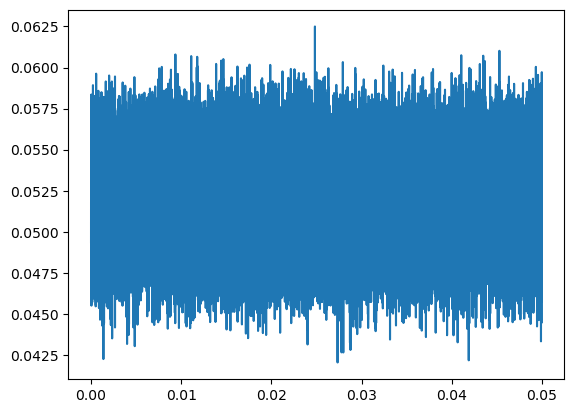

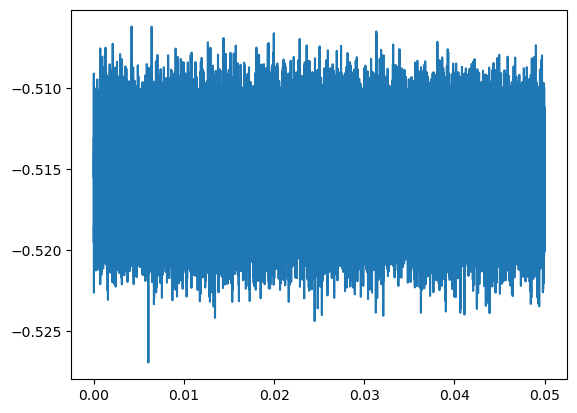

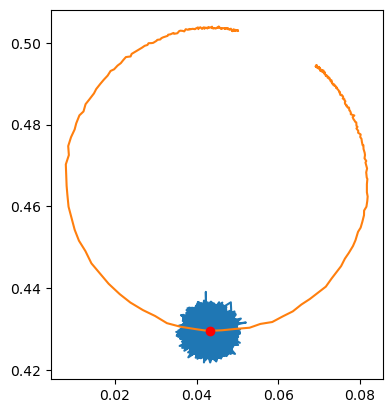

In [17]:
## 2.3 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')

In [19]:
### Ok so we have the resonator... lets test with LED

In [19]:
import serial 
print('imported serial')
from time import sleep

import time

imported serial


In [20]:
# Open the serial port
awg = serial.Serial(
    port='/dev/ttyUSB0',       # Replace with your COM port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    rtscts=True,  # Enable RTS/CTS (hardware handshaking),
    timeout=2
)
# Function to send SCPI commands
def send_command(inst, command):
    inst.write((command + '\n').encode())
    sleep(0.1)

# Function to query the instrument
def query_instrument(inst, command):
    send_command(inst, command)
    response = inst.readline().decode().strip()
    print(response)
    return

10000
()


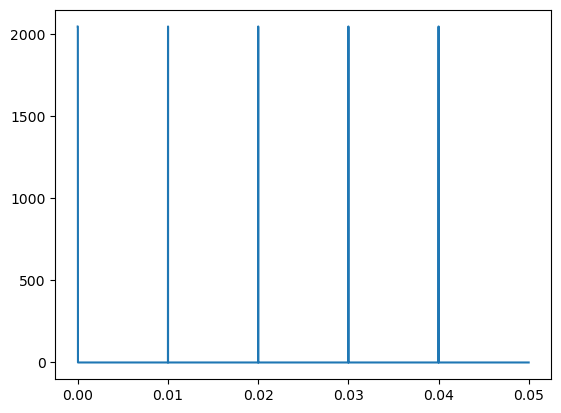

In [23]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10, 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, 1, 1, 1, 1]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data)


In [24]:
# Reset and configure the instrument
send_command(awg, '*RST')
send_command(awg,'*CLS')
send_command(awg,'FUNC:USER VOLATILE')
send_command(awg, 'OUTPut:LOAD INFinity')

In [25]:
start_time = time.time()
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

Time taken to download wavefunction: 416.698060 seconds


In [37]:
send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output

In [34]:
query_instrument(awg, 'OUTPut:LOAD?')

NameError: name 'query_instrument' is not defined

5.0


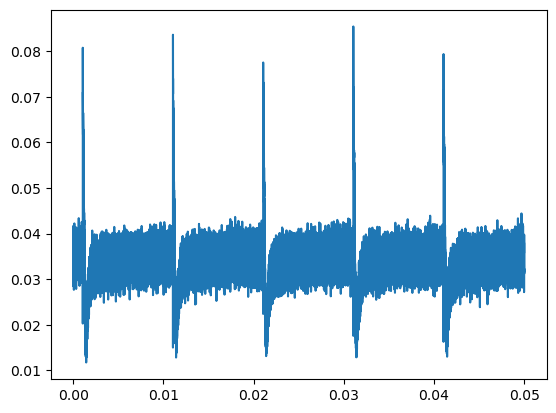

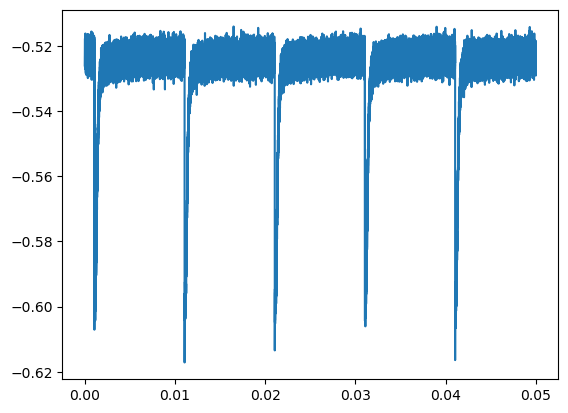

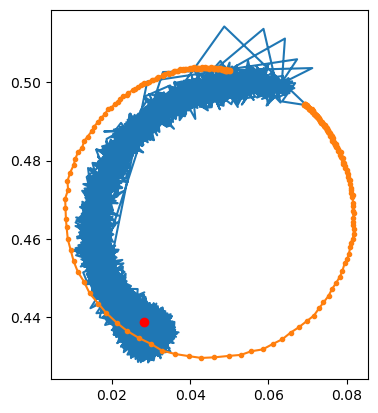

In [38]:
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')

In [41]:
send_command(awg,'OUTP OFF')  # Enable the output

10000
()


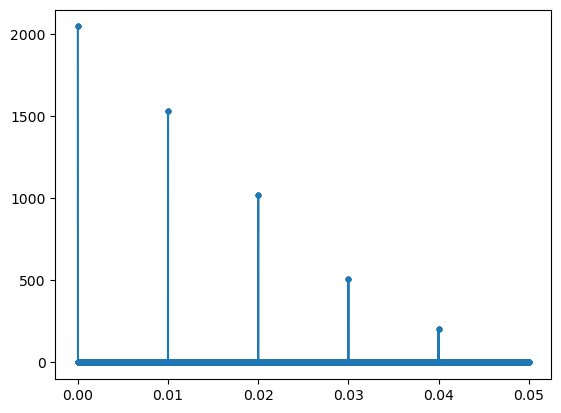

In [72]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [9, 9, 9, 9, 9] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [`=1, .75, .5, .25, .1]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)


In [73]:

#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

Time taken to download wavefunction: 416.698038 seconds


1
5.0
0


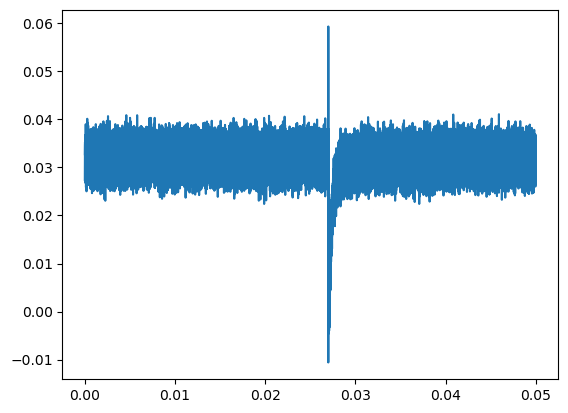

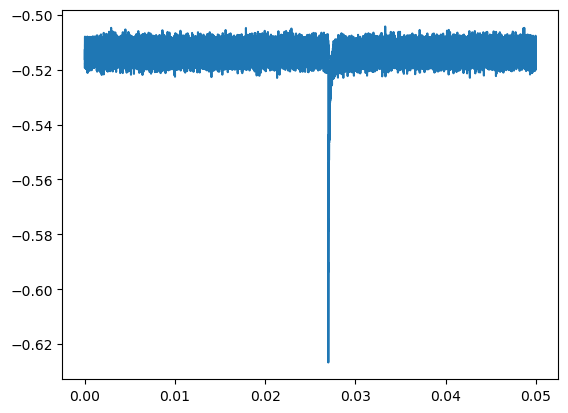

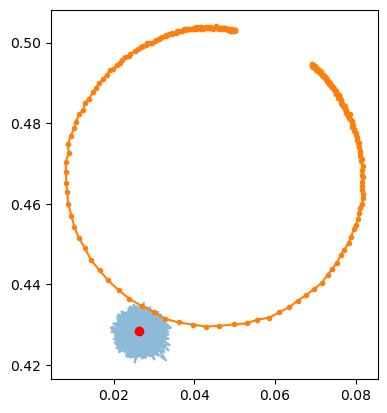

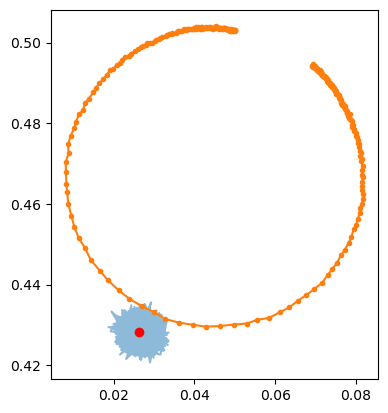

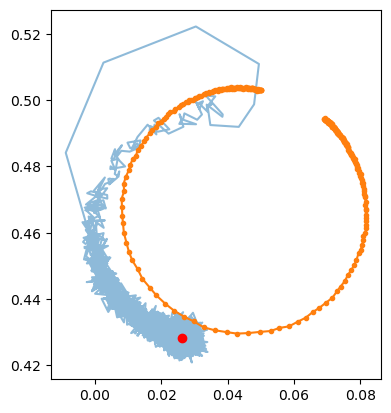

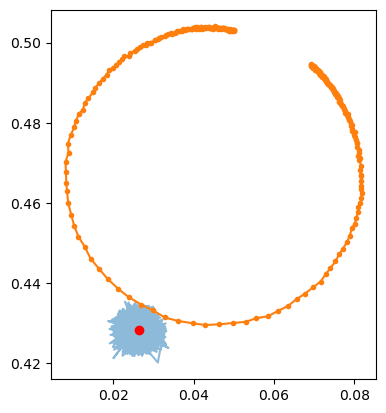

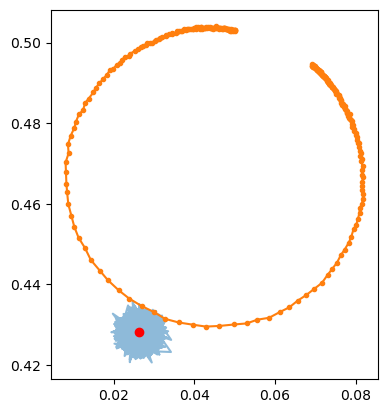

In [74]:
### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
i_chunks = chunk_data(2.4, (1/100)*1e6, i/(1.2),  start=0)
q_chunks = chunk_data(2.4, (1/100)*1e6, q/(-1.2),  start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk], alpha=0.5)
    tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
    plt.gca().set_aspect('equal')
    plt.show()


In [ ]:
from noise_utils import *

10000
()


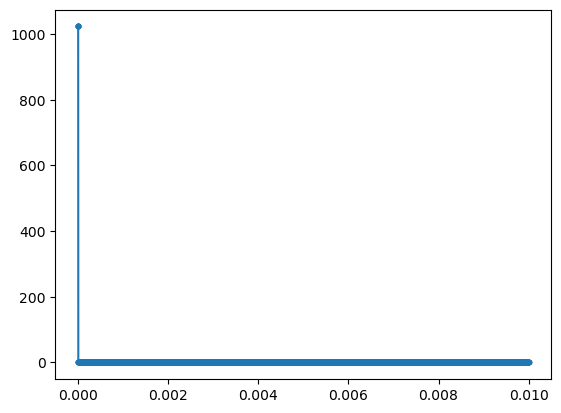

In [85]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 10e-3  # 50 ms total duration
total_samples = 10000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10]#, 9, 9, 9, 9] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [.5]#, .75, .5, .25, .1]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)


In [86]:

#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

Time taken to download wavefunction: 83.365030 seconds


1
2.0
0


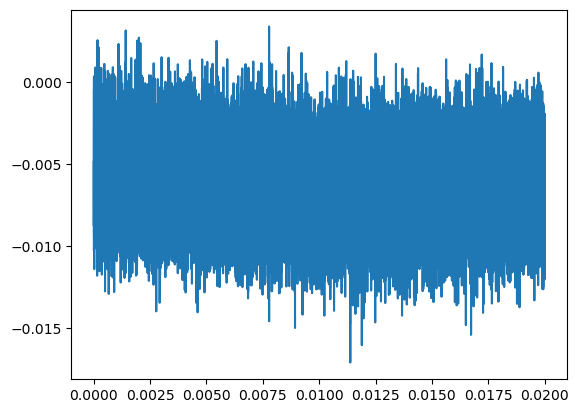

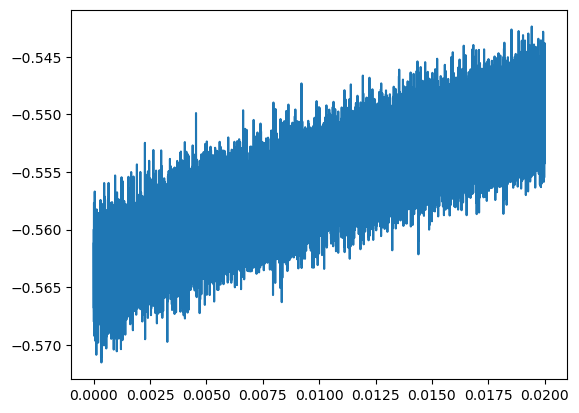

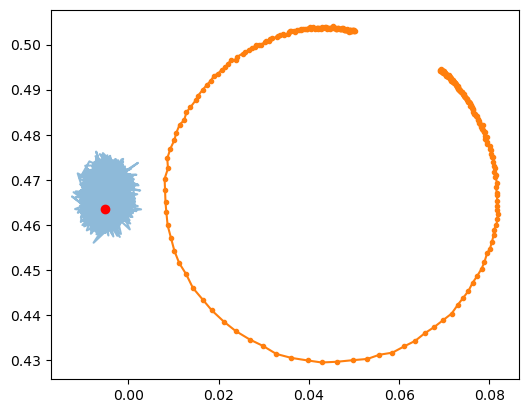

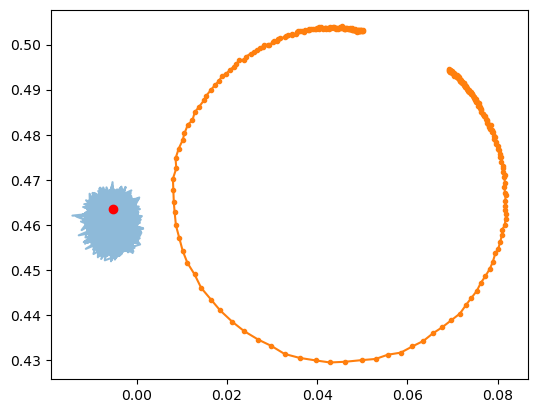

In [87]:

### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
i_chunks = chunk_data(2.4, (1/100)*1e6, i/(1.2),  start=0)
q_chunks = chunk_data(2.4, (1/100)*1e6, q/(-1.2),  start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk], alpha=0.5)
    tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
    plt.gca().set_aspect('equal')
    plt.show()


In [88]:
query_instrument(awg, 'OUTP?')

0


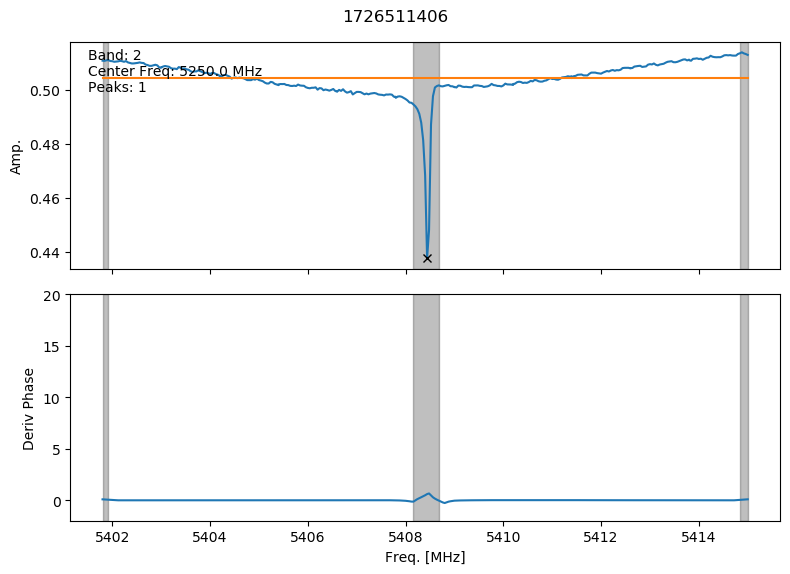

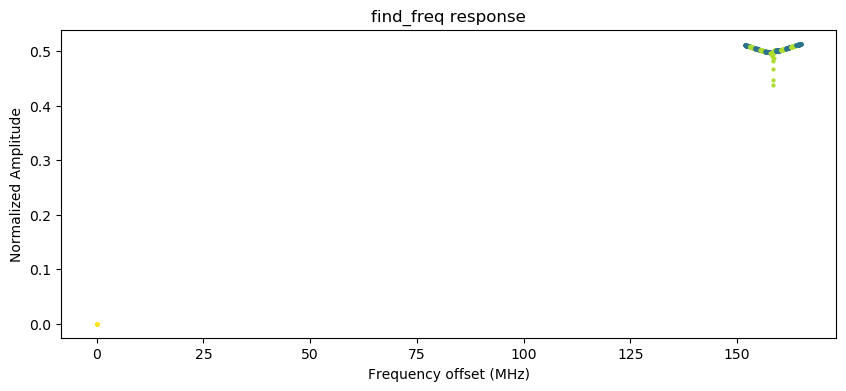

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [89]:
S.find_freq(2,start_freq=152,stop_freq=164,make_plot=True,show_plot=True,amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 

In [91]:
S.setup_notches(2,new_master_assignment=True)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone

5.0


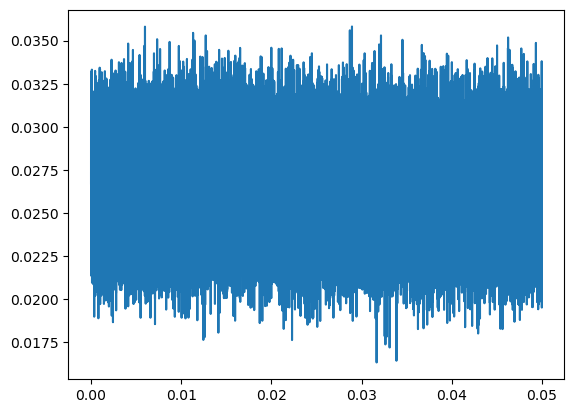

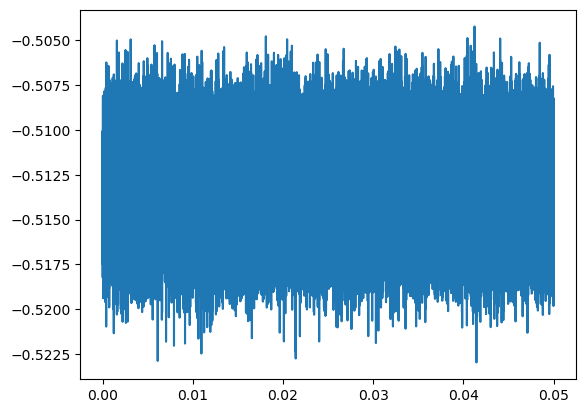

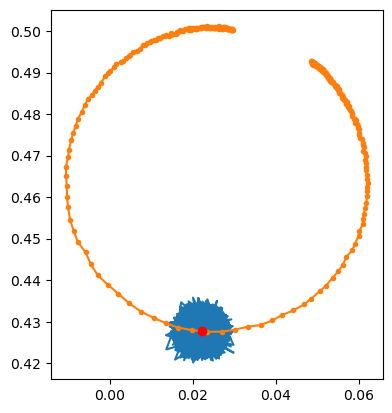

In [92]:
## 2.3 vpp

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')

10000
()


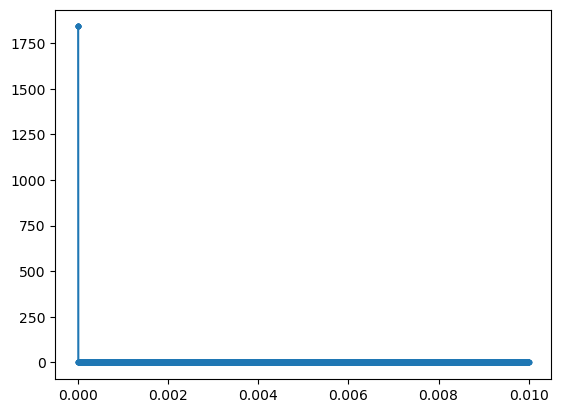

enter to download. 


Time taken to download wavefunction: 83.366778 seconds


enter to turn on and take data 


1
0.8333333333333334
0


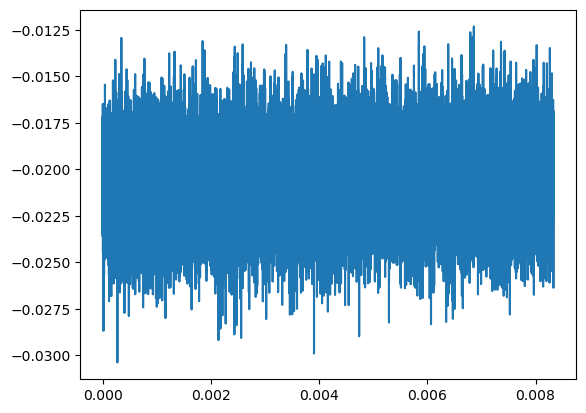

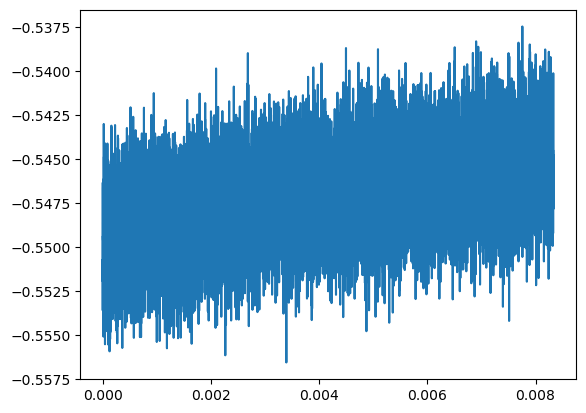

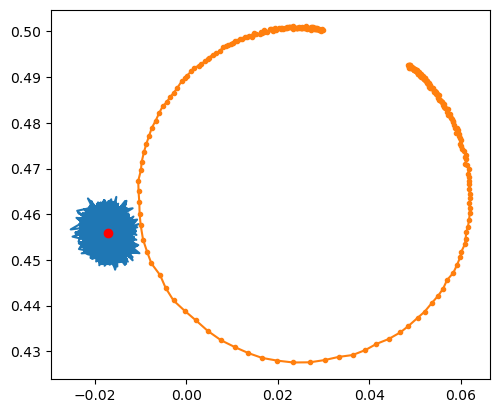

In [101]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 10e-3  # 50 ms total duration
total_samples = 10000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10]#, 9, 9, 9, 9] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [.9]#, .75, .5, .25, .1]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
plt.plot( i/(1.2),  q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')
plt.show()


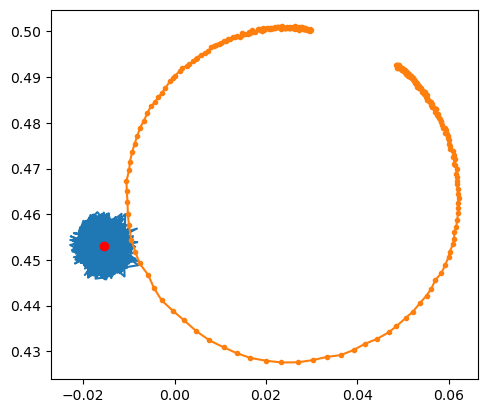

In [99]:
plt.plot( i/(1.2),  q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')
plt.show()

In [100]:
query_instrument(awg, 'OUTP?')

0


In [102]:
S.setup_notches(2,new_master_assignment=True)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone

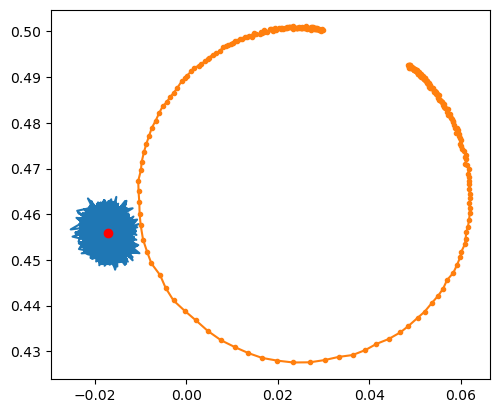

In [103]:
plt.plot( i/(1.2),  q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')
plt.show()

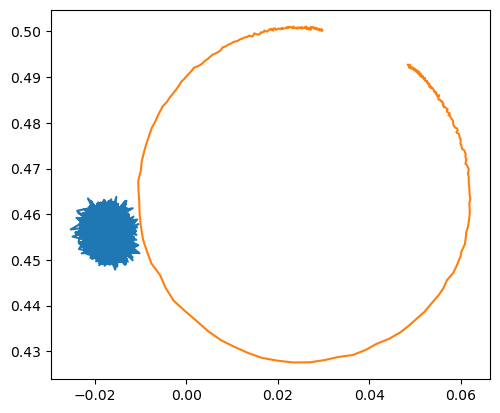

In [105]:
plt.plot(i/1.2, q/(-1.2))
plt.plot(tune_dict['r'].real, tune_dict['r'].imag)
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.gca().set_aspect('equal')

this is behaving so weird! 
1 V is WAYY to big, but .9 is too small? 

we are also drifting off of the resonant circle

also, it really does not look like we are on resonance. 

game plan? 

1. start the resonance fitter code up and running so we can be sure to hit it on res
2. try 0.95!

In [14]:
from KID_meas import *
def fit_data(tune_file, band, db_offset=1):
     
    tune_dict=load_tune_file(tune_file, band, db_offset)
     
    ##fit_tune_file returns two dictionaries, one with fit values and the other with errors. In each the keys are:
        ## f0: the resonant frequency
        ## Qr
        ## phi
        ## zoff (this is "a" in the usual equation form ie ae^{2piitau}....)
        ## QcHat
        ## tau
        ## Qc

    fit_dict, fine_errs = fit_tune_file(tune_dict, plot=True)
    print("Fit dictionary parameters:  ", fit_dict)

    plot_fit(tune_dict, fit_dict)
    
    return fit_dict, fine_errs
def plot_fit(tune_dict, fit_dict):

    ##This is the fit parameters plugged int othe fit function.
    iq_fit = resfunc3(tune_dict['freqs'], fit_dict['f0'], fit_dict['Qr'], fit_dict['QcHat'], fit_dict['zOff'], fit_dict['phi'],fit_dict['tau'])

    ##This is also the fit parameters plugged into the fit function, but the x data is only the resonant frequency (so returns one point).
    iq_res = resfunc3(fit_dict['f0'], fit_dict['f0'], fit_dict['Qr'], fit_dict['QcHat'], fit_dict['zOff'], fit_dict['phi'],fit_dict['tau'])

    ## This is the data rotated to the ideal basis
    VNA_ideal_basis = rotate_to_ideal_compact(tune_dict, fit_dict)
    ## This is the fit rotated to the ideal basis.
    fit_ideal_basis = rotate_to_ideal_semi_compact(iq_fit, tune_dict['freqs'], fit_dict)
    ## This is the resonance from the fit rotated to the ideal basis.
    iq_res_rotated = rotate_to_ideal_semi_compact(iq_res,  fit_dict['f0'], fit_dict)

    ## This is the frequency and dissipation basis values, from both the fit and the data.
    VNA_freq, VNA_diss = resonator_basis(VNA_ideal_basis, fit_dict, axis=None)
    fit_freq, fit_diss = resonator_basis(fit_ideal_basis, fit_dict, axis=None)
    iq_res_freq, iq_res_diss = resonator_basis(iq_res_rotated, fit_dict, axis=None)

    fig,axs = plt.subplots(ncols=2, figsize=(10, 10) )#sharex=True, sharey=True)

    print("Plotting iq, fit, and fr in ideal basis")
    axs[0].plot(tune_dict['r'].real, tune_dict['r'].imag,'C0.-', label='VNA iq')
    axs[0].plot(iq_fit.real, iq_fit.imag,'C1-', label='fit')
    axs[0].plot(iq_res.real, iq_res.imag, 'ro', label='fr from fit')
    axs[0].legend()

    print("Plotting iq, fit, and fr in resonator basis")
    axs[1].plot(VNA_ideal_basis.real, VNA_ideal_basis.imag,'C0.-', label='VNA iq in ideal basis')
    axs[1].plot(fit_ideal_basis.real, fit_ideal_basis.imag,'C1-', label='rotated fit')
    axs[1].plot(iq_res_rotated.real, iq_res_rotated.imag, 'ro', label='rotated fr from fit')
    
    
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    axs[0].set_ylabel("Q, unrotated")
    axs[1].set_ylabel("Q, rotated")
    axs[0].set_xlabel("I, unrotated")
    axs[1].set_xlabel("I, rotated")
    
    return None
def rotate_to_ideal_compact(tune_dict, fopt):  
    # osmond
    z = tune_dict['r']
    f = tune_dict['freqs']
    fr = fopt['f0']
    a =  fopt['zOff']
    tau =  fopt['tau']
    phi = fopt['phi']
    return 1-((1-z/(a*np.exp(-2j*np.pi*(f-fr)*tau)))*(np.cos(phi)/np.exp(1j*phi)))
def rotate_to_ideal_semi_compact(z, f, fopt):  
    # osmond
    fr = fopt['f0']
    a =  fopt['zOff']
    tau =  fopt['tau']
    phi = fopt['phi']
    return 1-((1-z/(a*np.exp(-2j*np.pi*(f-fr)*tau)))*(np.cos(phi)/np.exp(1j*phi)))


Fr from fit  [GHz]: 5408.463969329484
Fr min curve [GHz]: 5408.455999999999
fine_pars: {'f0': 5408.463969329484, 'Qr': 63799.311681782354, 'phi': -0.33737285005140166, 'zOff': (0.026104317148522672+0.4976327733320014j), 'QcHat': 434789.4435075595, 'tau': (0.00010628946662299683-0.0001047330710143914j), 'Qc': 460763.83837448154}
Qi: 54965.38889515718
Fit dictionary parameters:   {'f0': 5408.463969329484, 'Qr': 63799.311681782354, 'phi': -0.33737285005140166, 'zOff': (0.026104317148522672+0.4976327733320014j), 'QcHat': 434789.4435075595, 'tau': (0.00010628946662299683-0.0001047330710143914j), 'Qc': 460763.83837448154}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


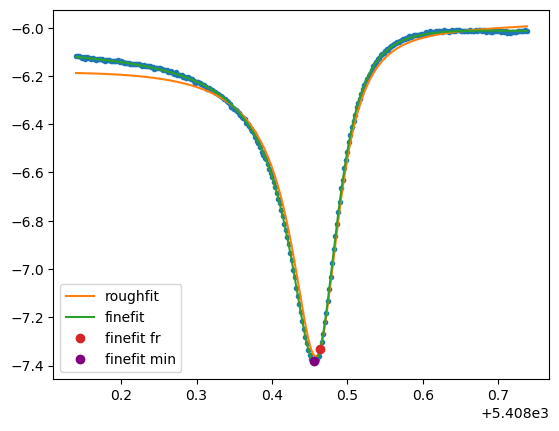

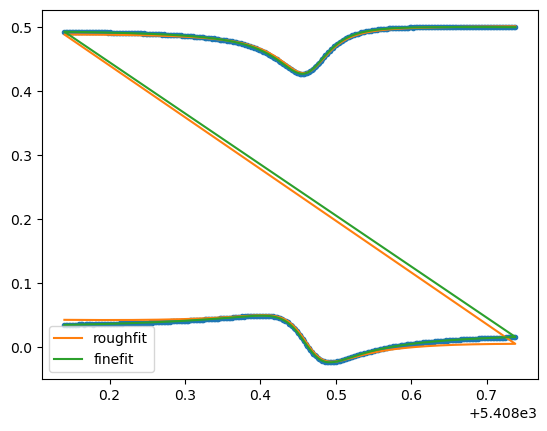

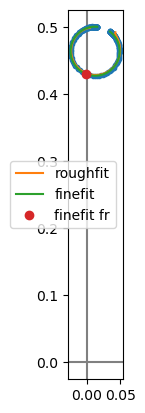

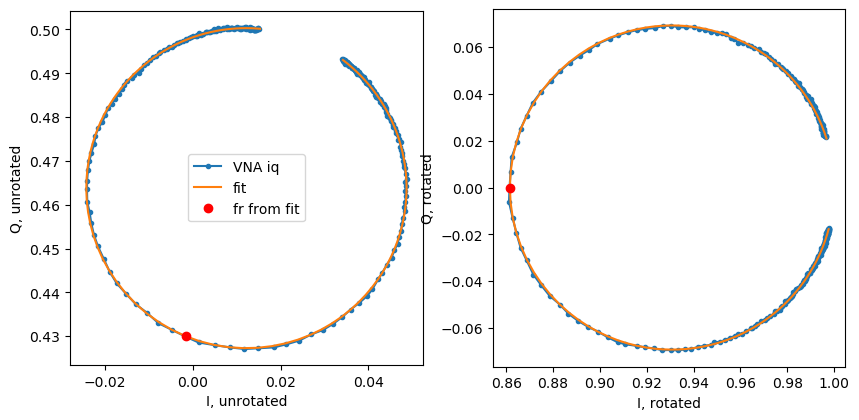

In [119]:
fit_dict, fit_errs = fit_data(S.tune_file)



In [120]:
S.channel_off(2,66)

In [122]:
S.set_fixed_tone(fit_dict['f0'], 12)

(2, 66)

5.0


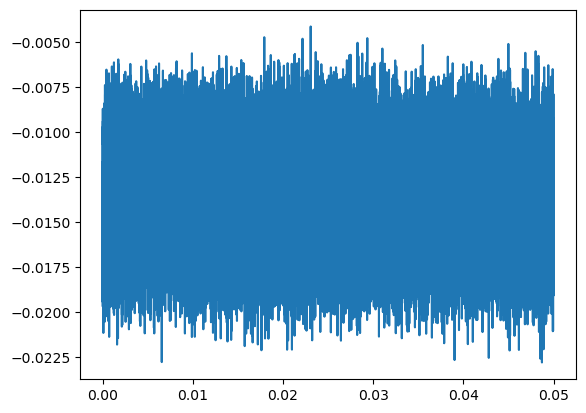

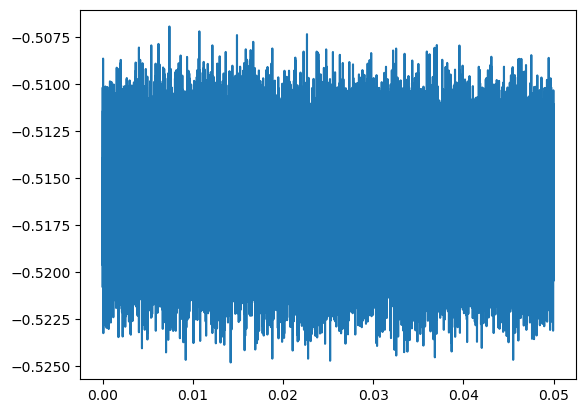

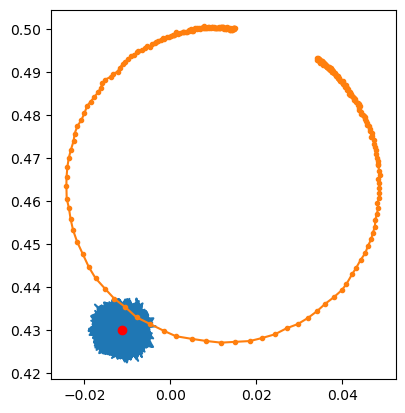

In [123]:
## 2.3 vpp
fit_dict, fit_errs = fit_data(S.tune_file)

S.set_fixed_tone(fit_dict['f0'], 12)

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time = np.arange(len(i))/(2.4e6)
plt.plot(time, i)
plt.ylim()
plt.show()
plt.plot(time, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')

In [132]:
for ch in S.which_on(2):
    S.channel_off(2, ch)

In [133]:
S.setup_notches(2,new_master_assignment=True)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone
for ch in S.which_on(2):
    S.channel_off(2, ch)

Fr from fit  [GHz]: 5408.463064359522
Fr min curve [GHz]: 5408.455999999999
fine_pars: {'f0': 5408.463064359522, 'Qr': 63524.75463965851, 'phi': -0.3392531596506106, 'zOff': (-0.038223373534519114+0.4937286702858904j), 'QcHat': 435766.94274398003, 'tau': (0.00014115052944300817-0.00019988334714337306j), 'Qc': 462105.3466787528}
Qi: 54792.125854832644
Fit dictionary parameters:   {'f0': 5408.463064359522, 'Qr': 63524.75463965851, 'phi': -0.3392531596506106, 'zOff': (-0.038223373534519114+0.4937286702858904j), 'QcHat': 435766.94274398003, 'tau': (0.00014115052944300817-0.00019988334714337306j), 'Qc': 462105.3466787528}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis
5.0


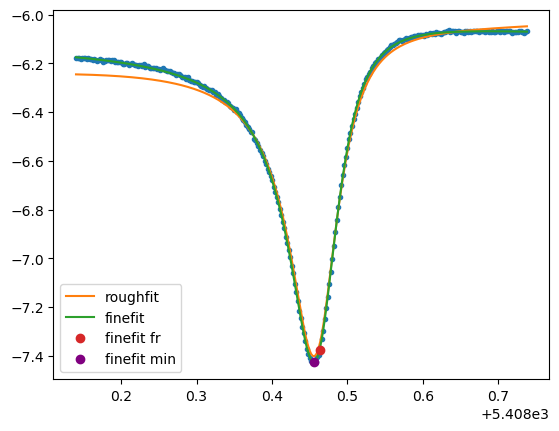

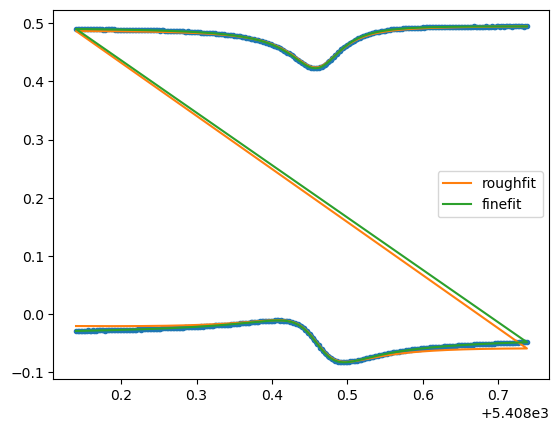

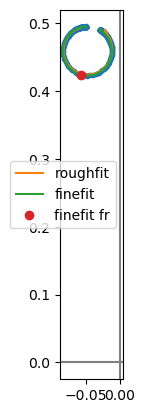

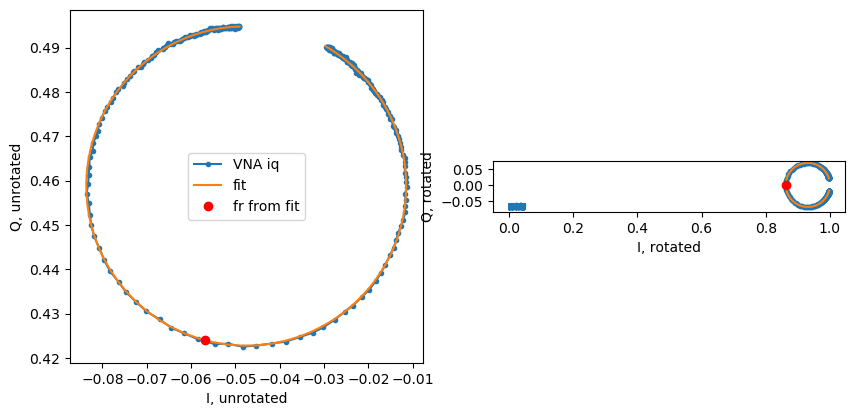

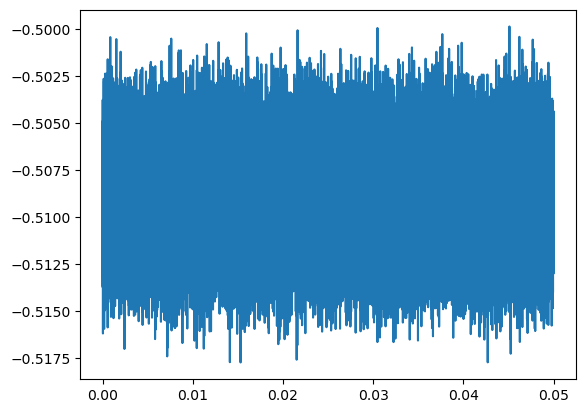

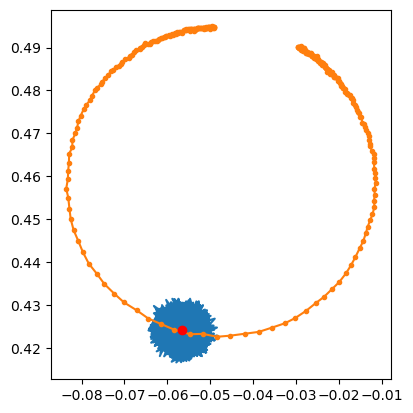

In [134]:
for ch in S.which_on(2):
    S.channel_off(2, ch)
## 2.3 vpp
fit_dict, fit_errs = fit_data(S.tune_file)

S.set_fixed_tone(fit_dict['f0'], 12)

band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 5

# nsamp = 2**20
nsamp= int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
plt.plot(i/1.2, q/(-1.2))
tune_dict=load_tune_file(S.tune_file, band, db_offset=1)
plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
plt.plot(np.mean(i/1.2), np.mean(q/(-1.2)), 'ro')
plt.gca().set_aspect('equal')

In [135]:
query_instrument(awg, 'OUTP?')

0


In [138]:
import time

10000
()


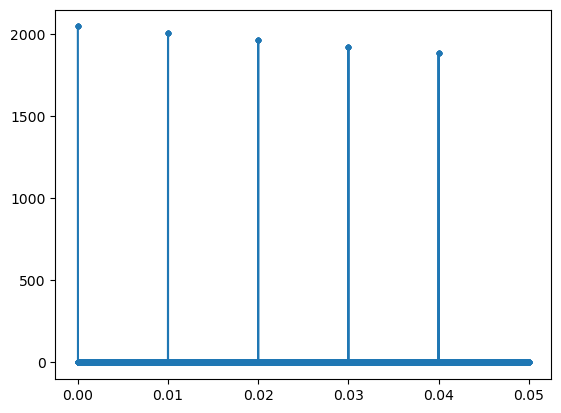

enter to download. 


Time taken to download wavefunction: 417.016830 seconds
1
4.166666666666667
0


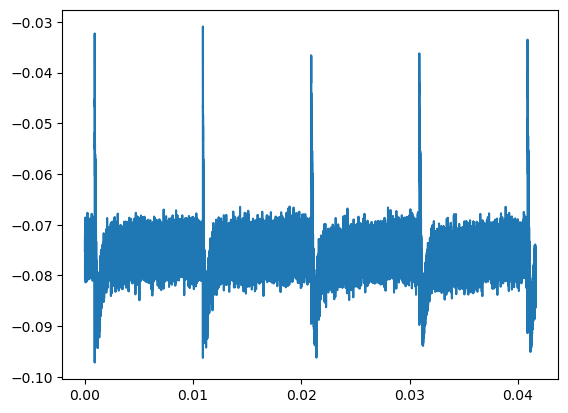

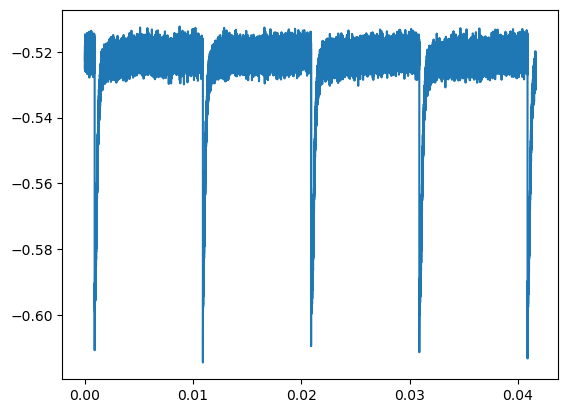

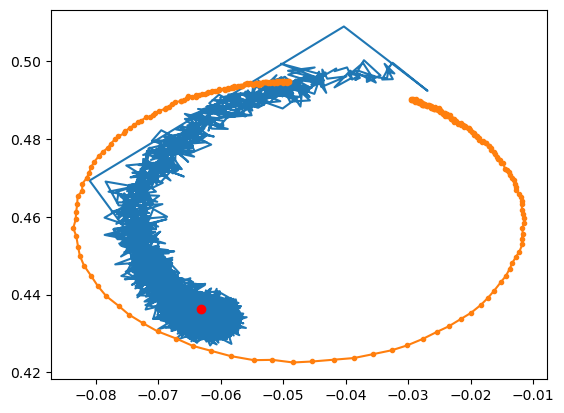

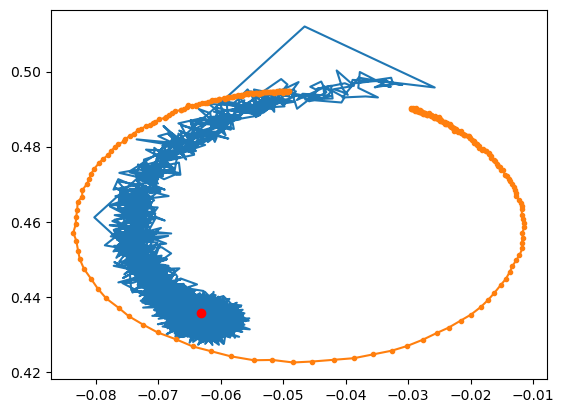

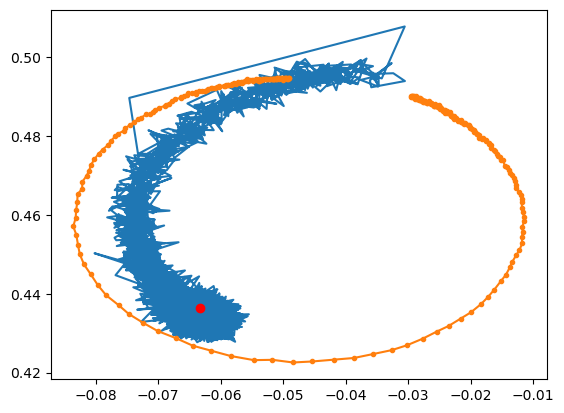

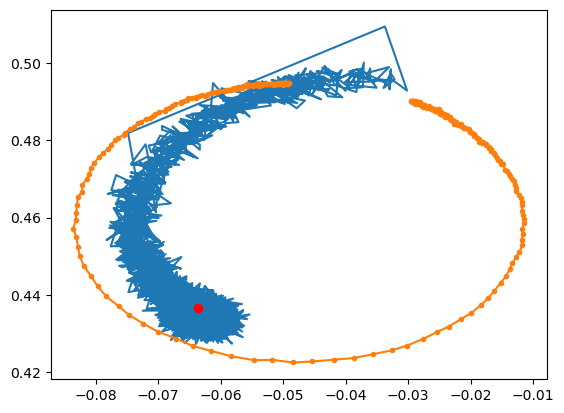

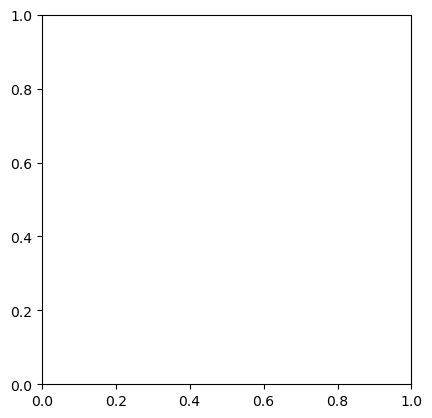

In [140]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, .98, .96, .94, .92]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.show()
plt.gca().set_aspect('equal')



10000
()


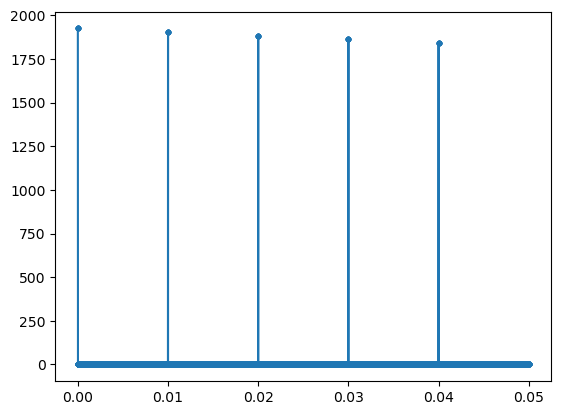

enter to download. 


Time taken to download wavefunction: 417.024688 seconds
1
4.166666666666667
0


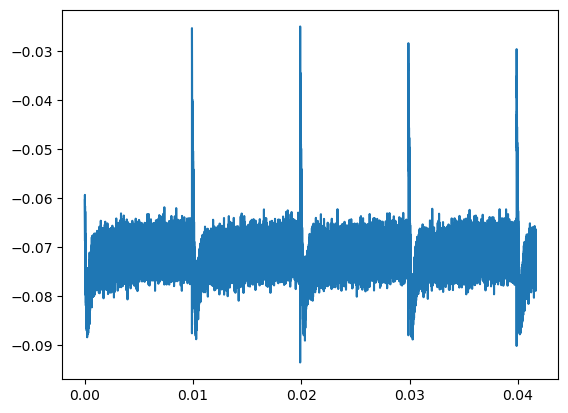

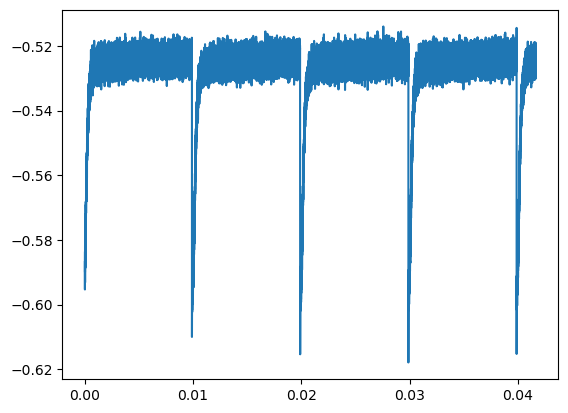

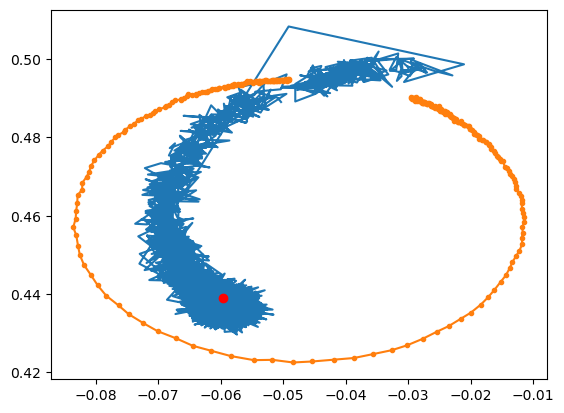

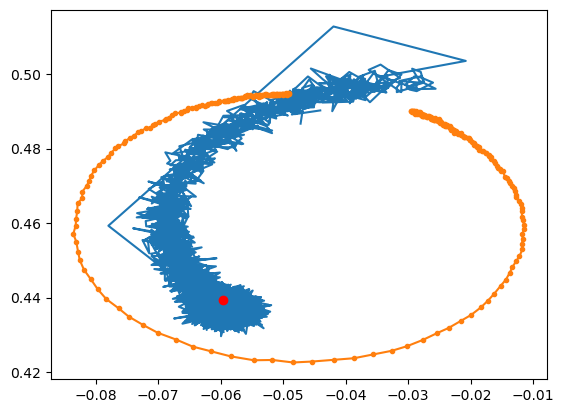

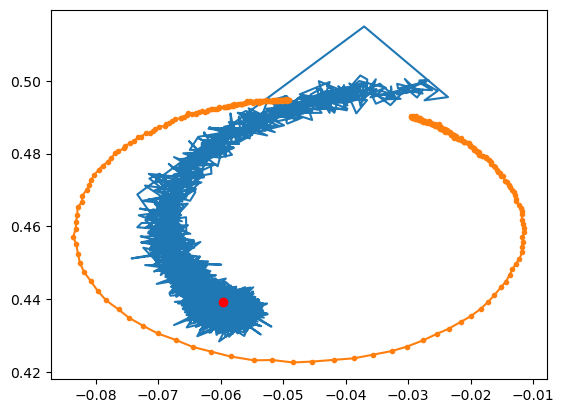

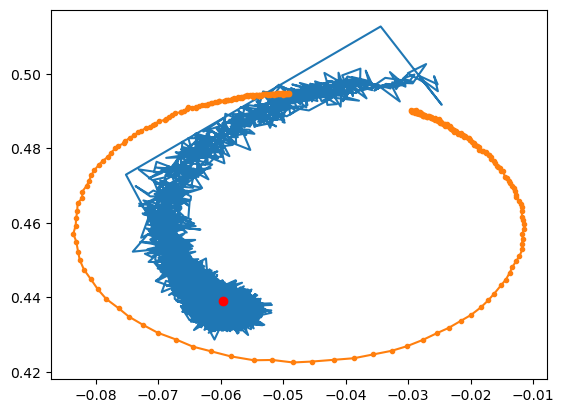

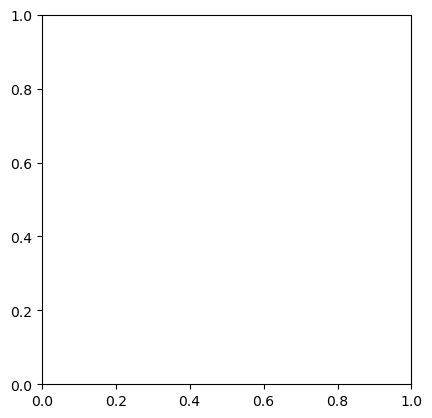

In [141]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [.94, .93, .92, .91, .9]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.show()
plt.gca().set_aspect('equal')



1
4.166666666666667
0


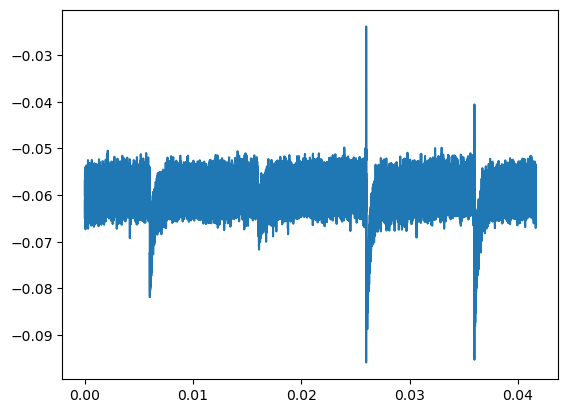

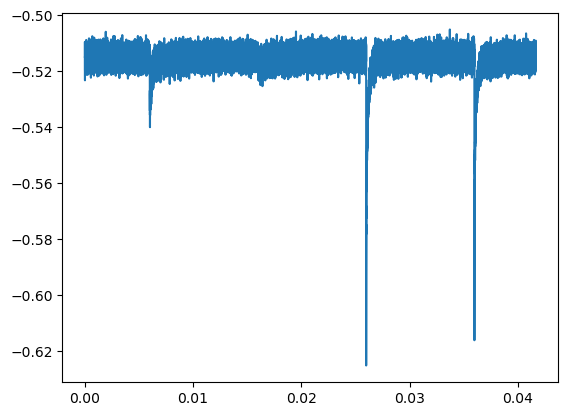

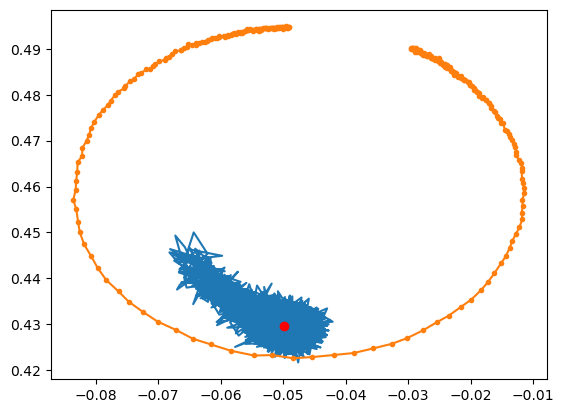

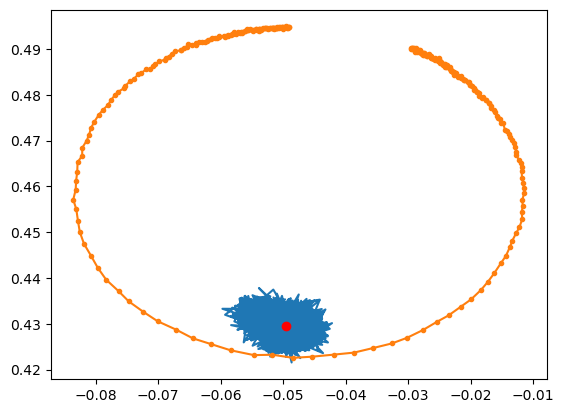

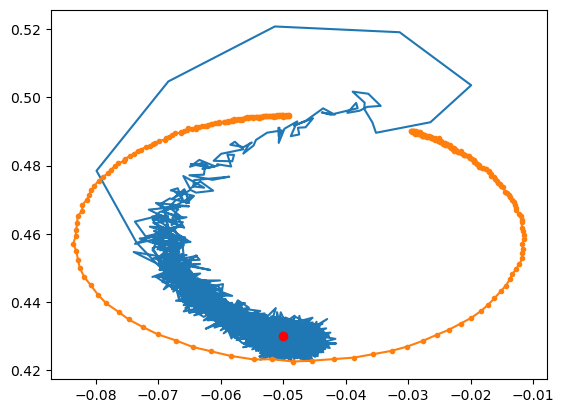

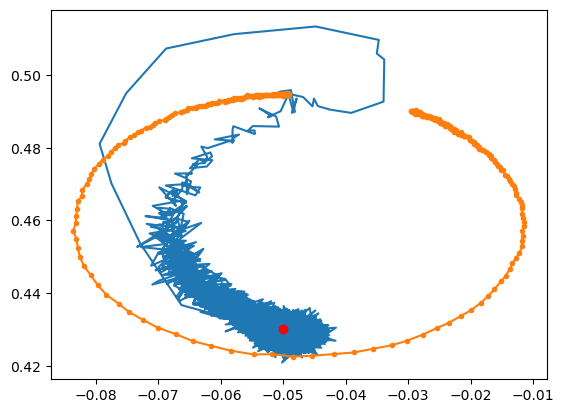

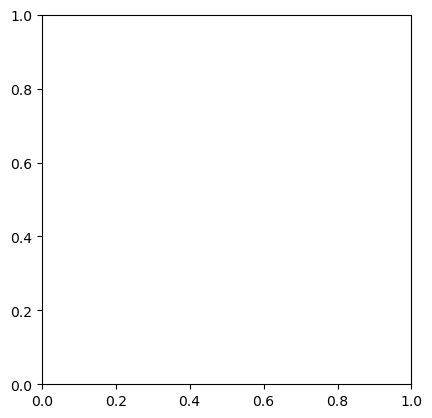

In [145]:
### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 0.85')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.show()
plt.gca().set_aspect('equal')

1
4.166666666666667
0


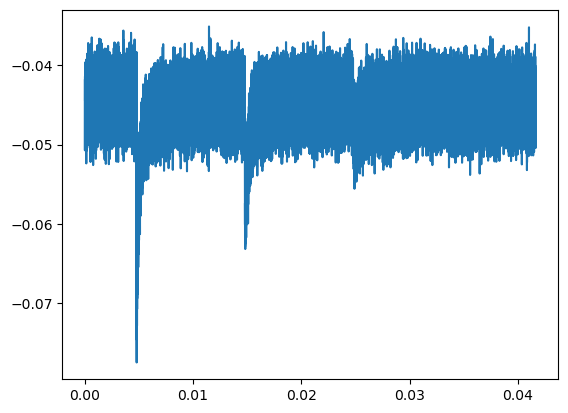

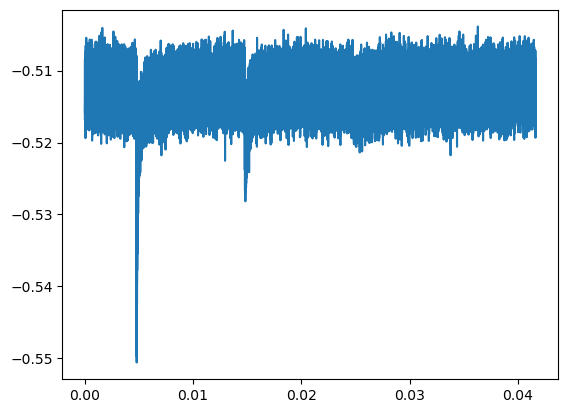

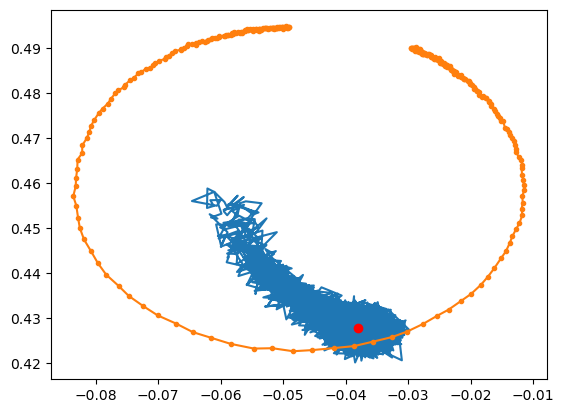

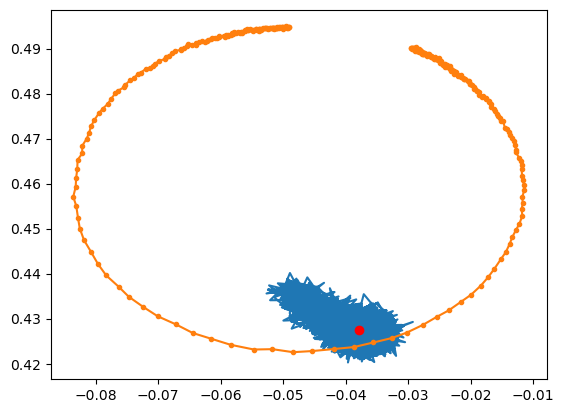

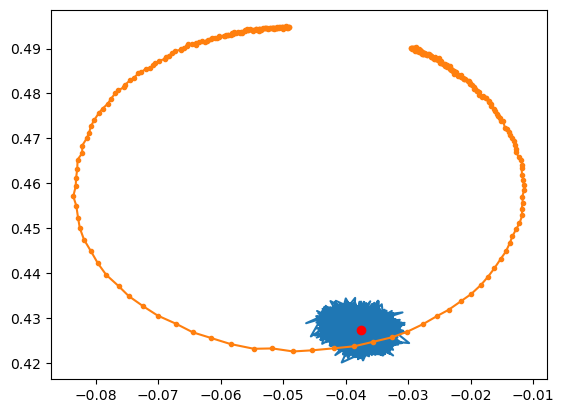

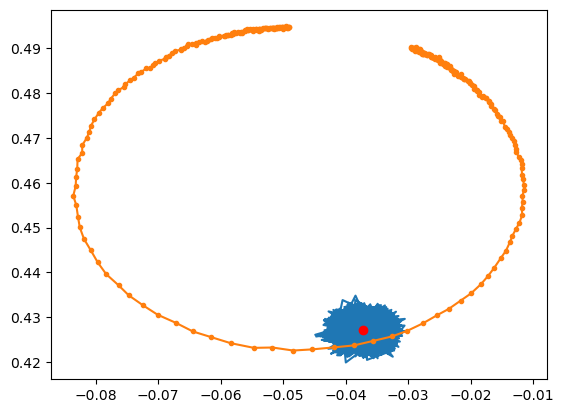

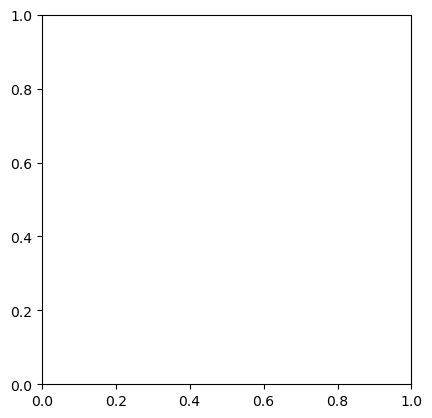

In [146]:
### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 0.83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.show()
plt.gca().set_aspect('equal')

10000
()


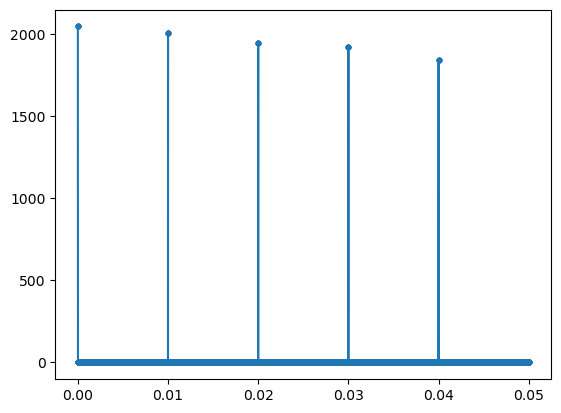

enter to download. 


Time taken to download wavefunction: 417.018218 seconds
1
4.166666666666667
0


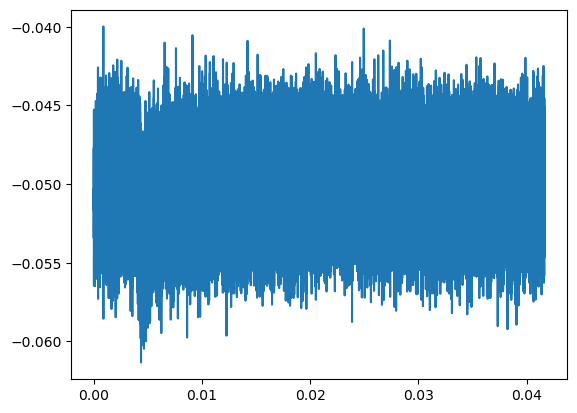

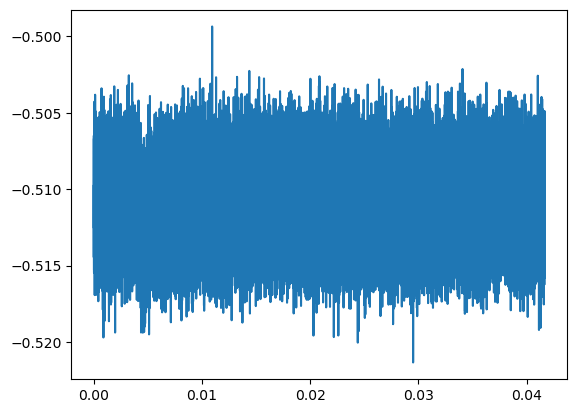

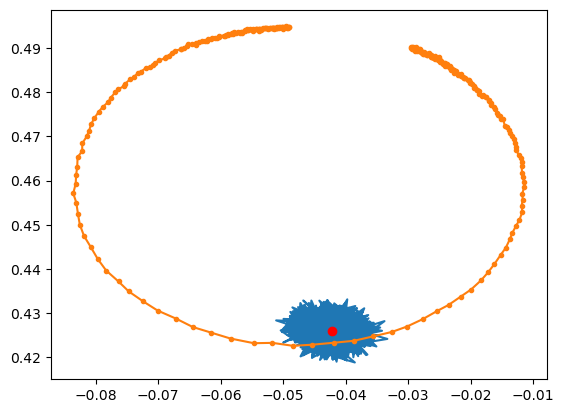

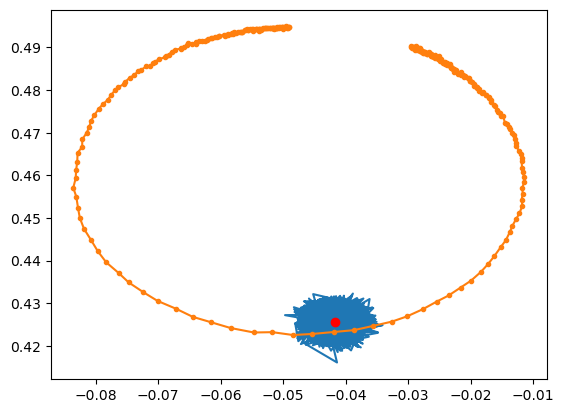

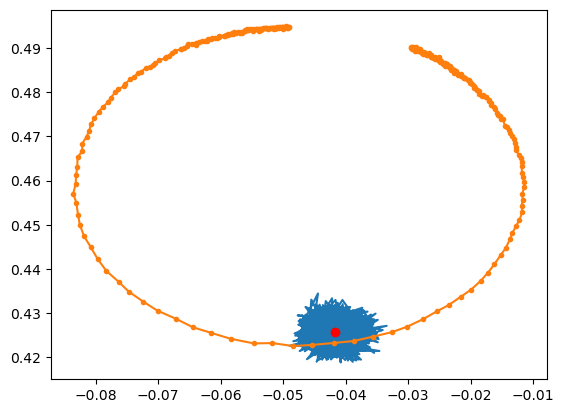

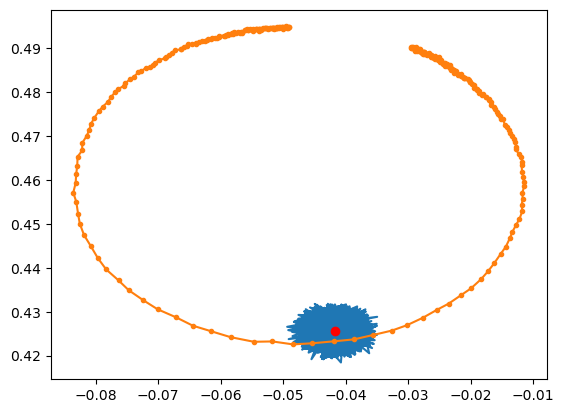

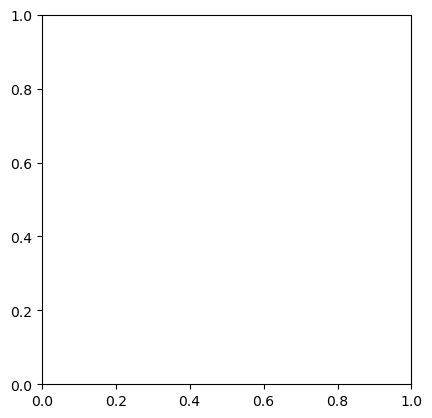

In [147]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, .98, .95, .94, .9]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.show()
plt.gca().set_aspect('equal')



In [154]:
S.setup_notches(2,new_master_assignment=True, tone_power=13)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone
for ch in S.which_on(2):
    S.channel_off(2, ch)

Fr from fit  [GHz]: 5408.464360579859
Fr min curve [GHz]: 5408.455999999999
fine_pars: {'f0': 5408.464360579859, 'Qr': 64010.75324388767, 'phi': -0.34201812280998334, 'zOff': (-0.028426209596307563+0.7030167805852674j), 'QcHat': 435908.6482696993, 'tau': (-7.596989181114096e-05-0.0003180587839237026j), 'Qc': 462708.8718727179}
Qi: 55155.559881662746
Fit dictionary parameters:   {'f0': 5408.464360579859, 'Qr': 64010.75324388767, 'phi': -0.34201812280998334, 'zOff': (-0.028426209596307563+0.7030167805852674j), 'QcHat': 435908.6482696993, 'tau': (-7.596989181114096e-05-0.0003180587839237026j), 'Qc': 462708.8718727179}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


(2, 66)

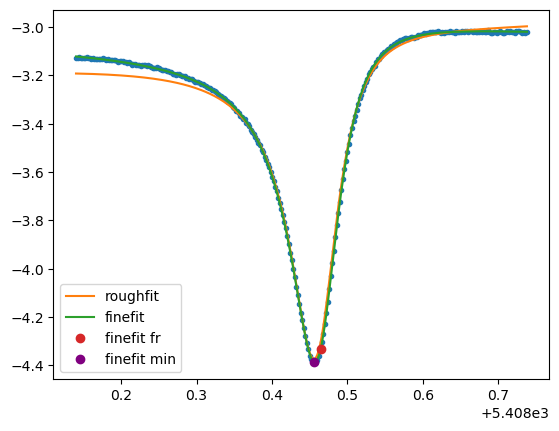

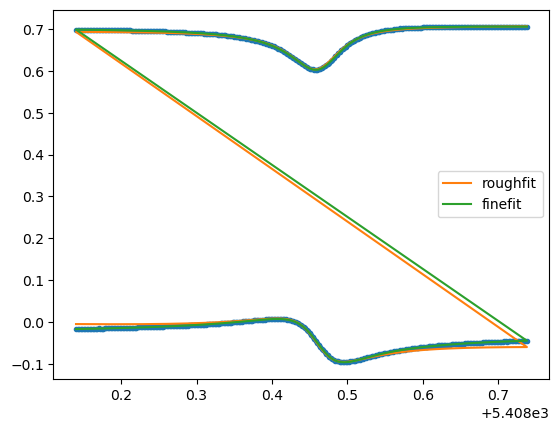

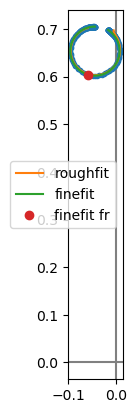

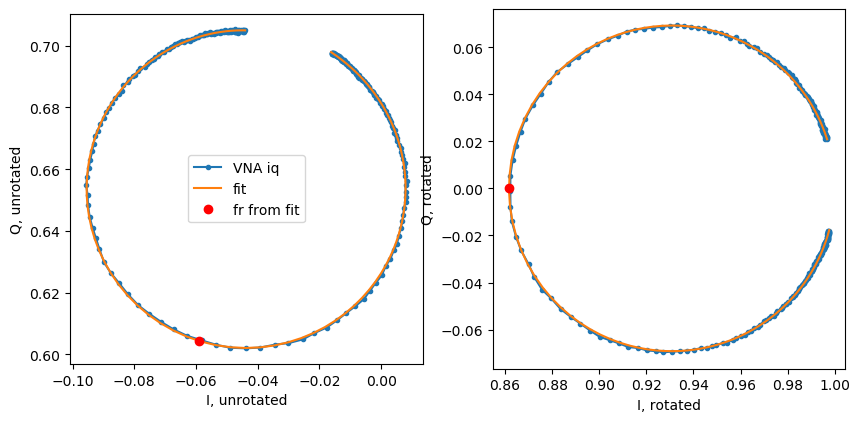

In [155]:
S.setup_notches(2,new_master_assignment=True, tone_power=13)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone
    
for ch in S.which_on(2):
    S.channel_off(2, ch)
## 2.3 vpp
fit_dict, fit_errs = fit_data(S.tune_file)

S.set_fixed_tone(fit_dict['f0'], 12)

1
4.166666666666667
0


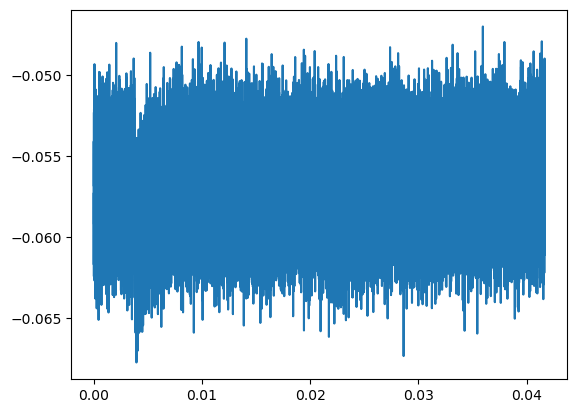

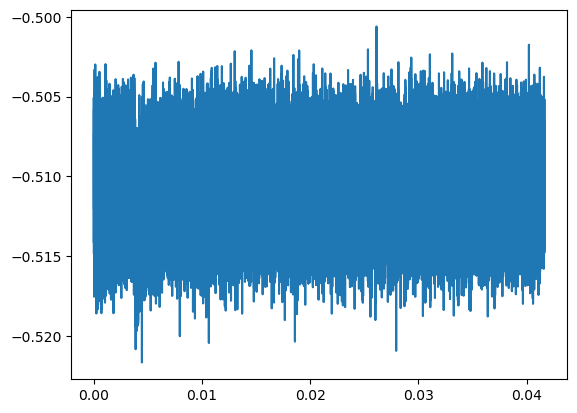

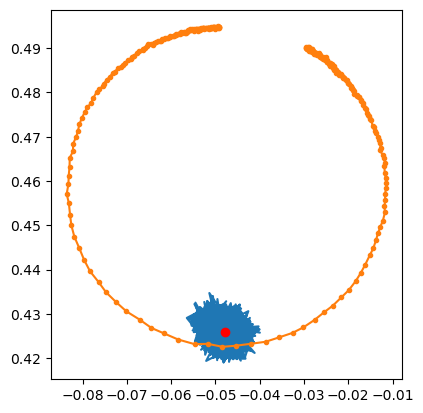

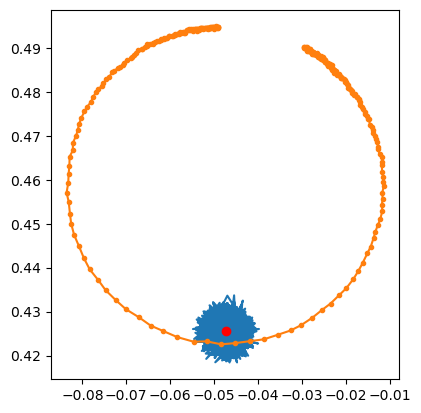

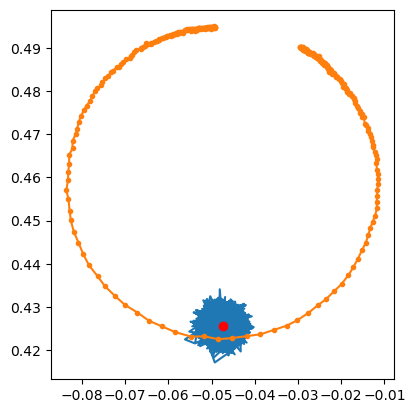

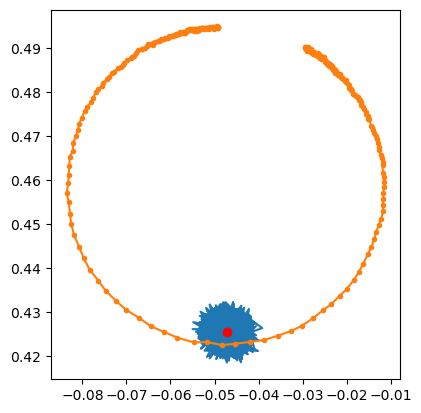

In [158]:
### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()



1
4.166666666666667
0


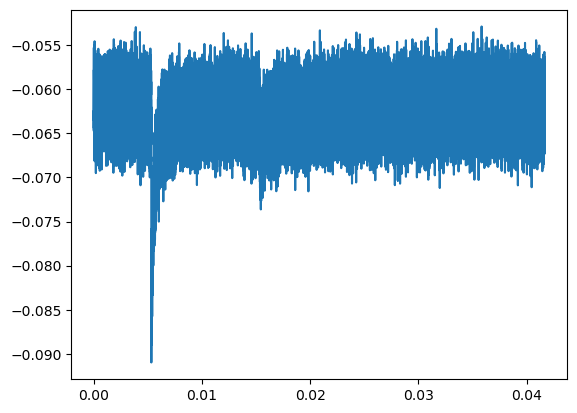

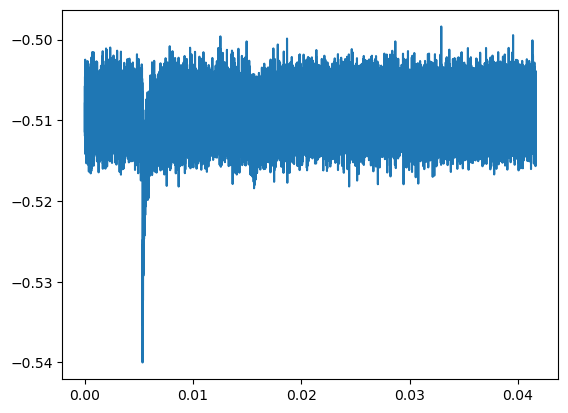

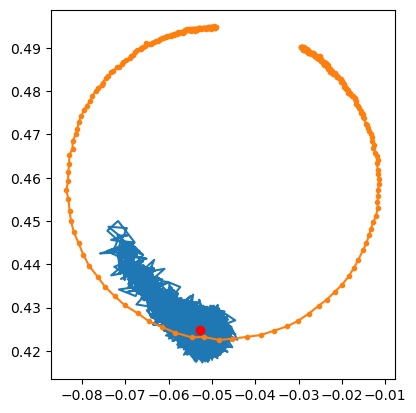

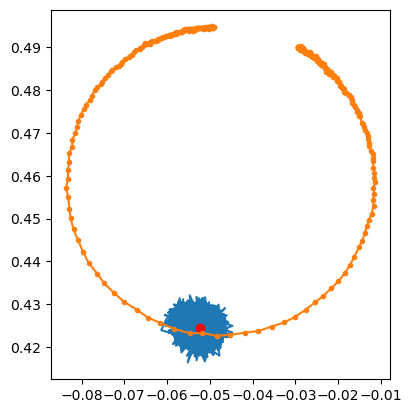

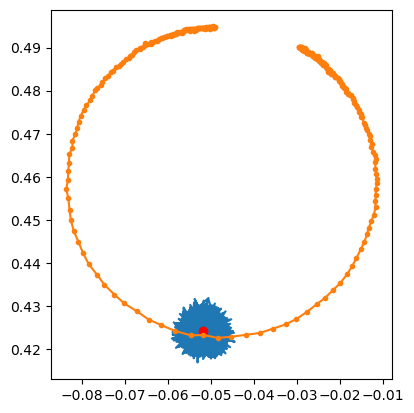

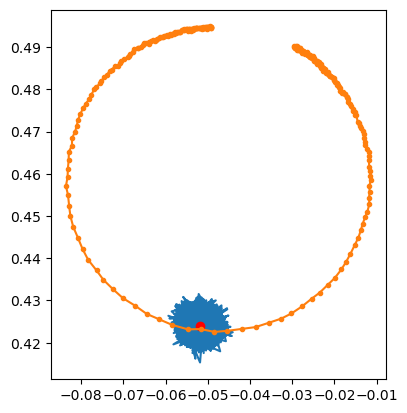

In [159]:
### send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()



1
4.166666666666667
0


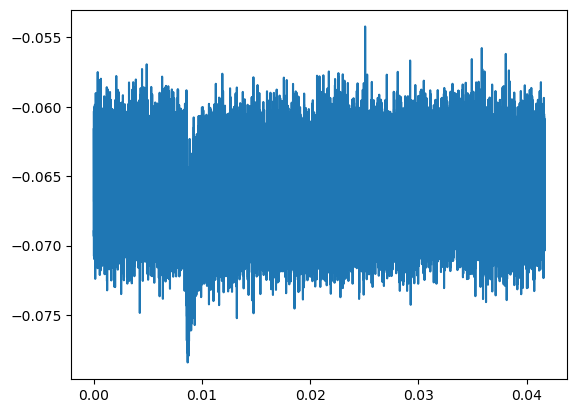

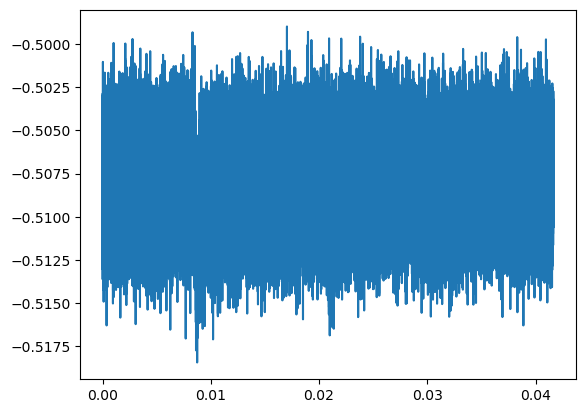

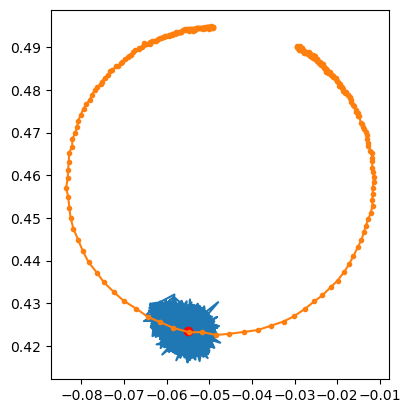

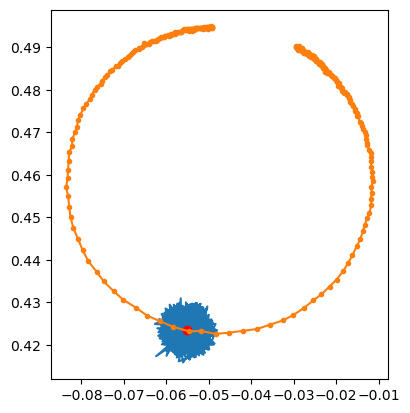

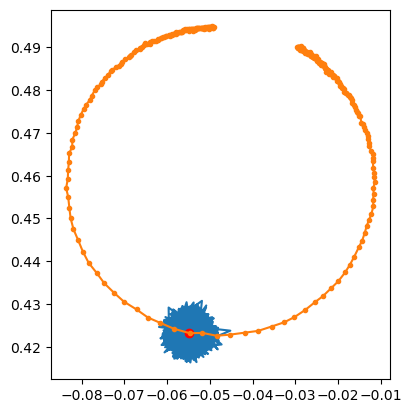

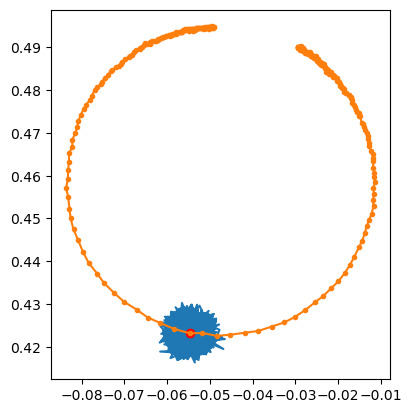

In [160]:


## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()



10000
()


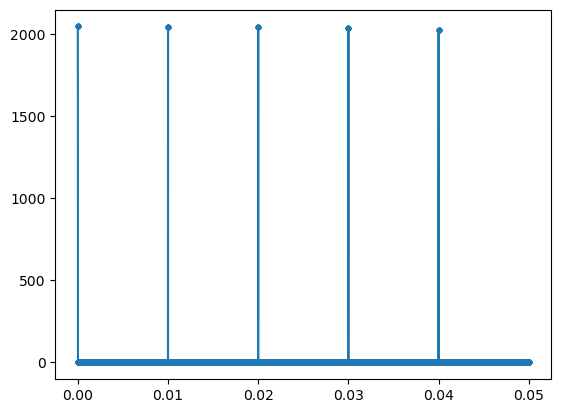

enter to download. 


Time taken to download wavefunction: 417.021057 seconds
1
4.166666666666667
0


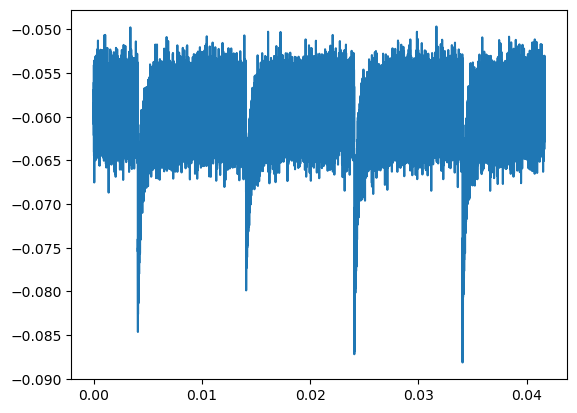

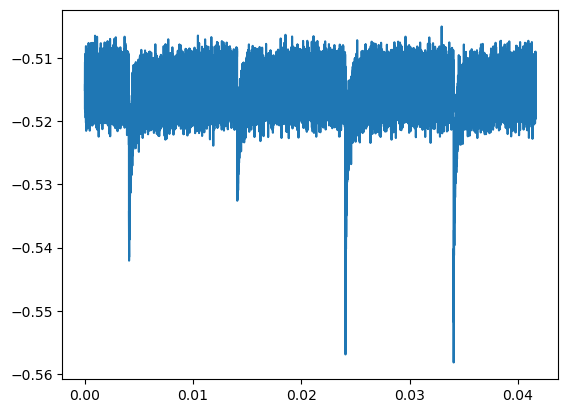

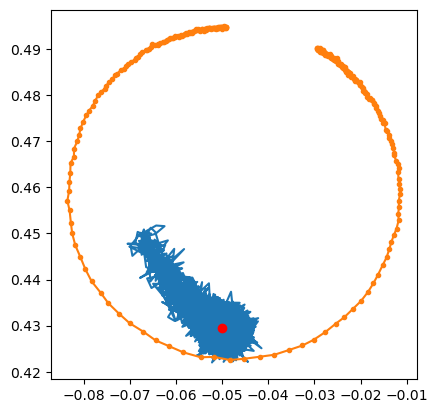

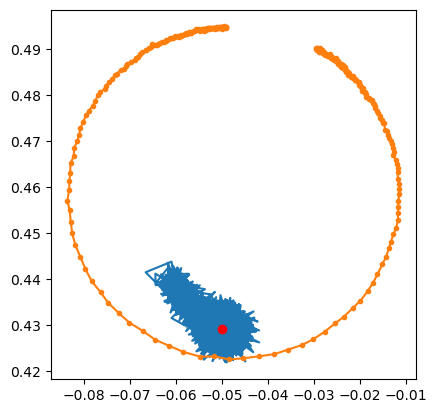

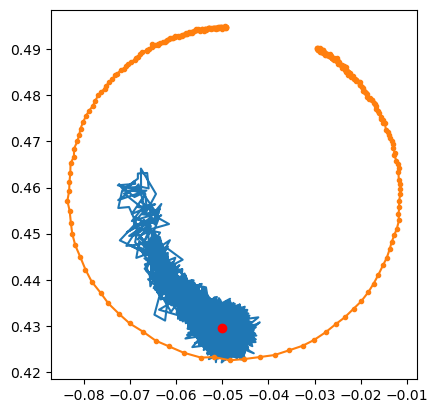

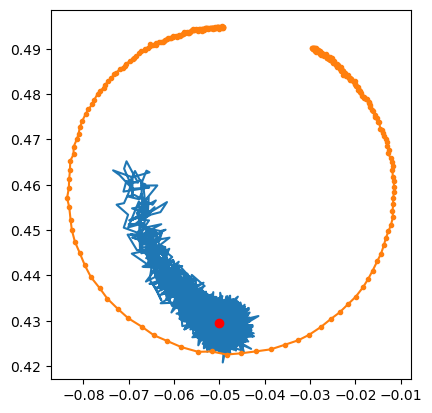

In [161]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, .999, .998, .995, .990]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")


## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()



10000
()


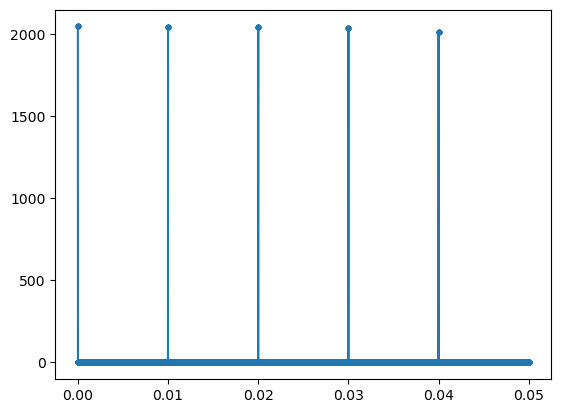

enter to download. 


Time taken to download wavefunction: 417.016272 seconds
1
4.166666666666667
0


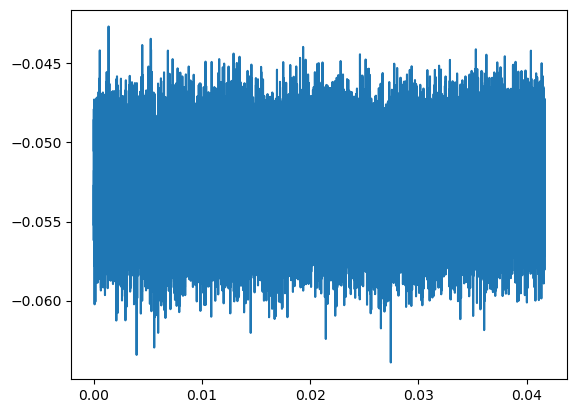

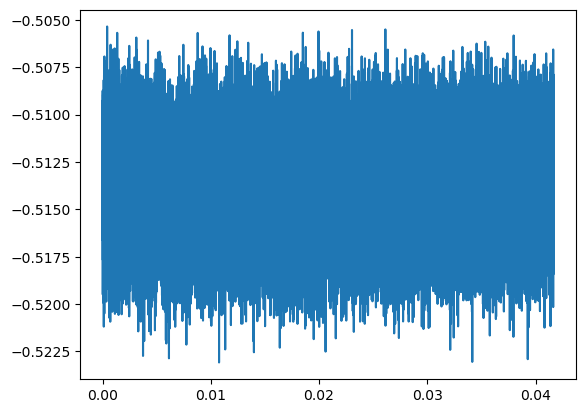

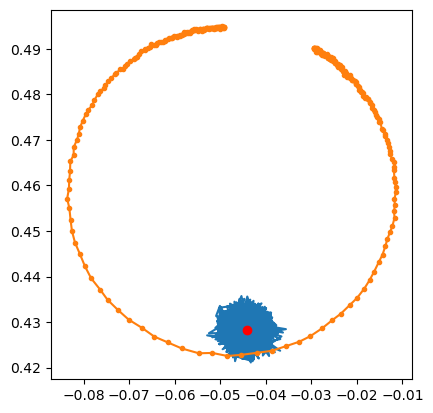

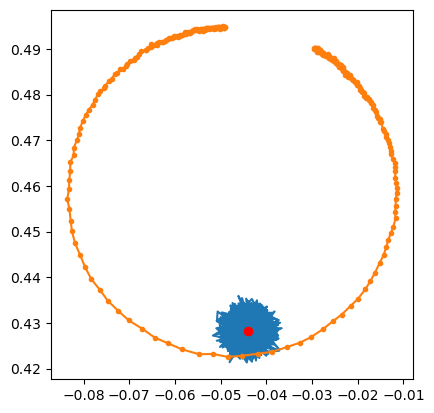

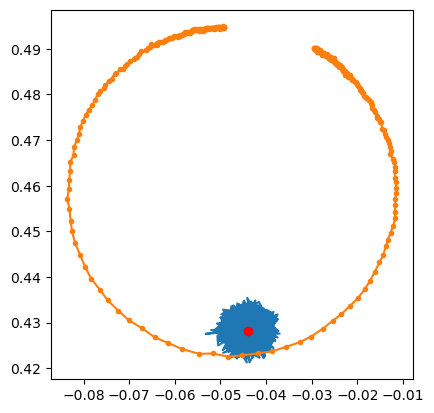

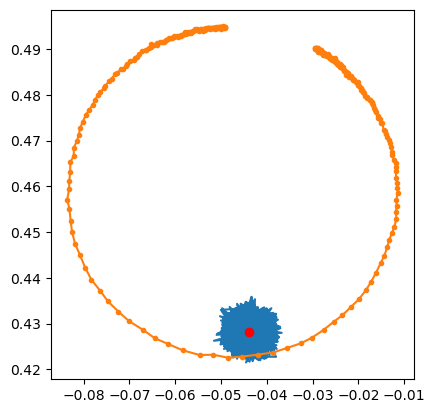

In [162]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, .999, .998, .995, .985]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data, 'C0.-')
#plt.xlim(-0.00001,0.000011)
plt.show()
input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")


## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .81')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()



Fr from fit  [GHz]: 5408.46422375549
Fr min curve [GHz]: 5408.455999999999
fine_pars: {'f0': 5408.46422375549, 'Qr': 64215.89992121482, 'phi': -0.3352253462808161, 'zOff': (0.1159281099885218+0.7043376770778181j), 'QcHat': 438897.79620228196, 'tau': (-8.483872907874999e-05+9.411899545882152e-05j), 'Qc': 464768.5821911387}
Qi: 55343.35138695182
Fit dictionary parameters:   {'f0': 5408.46422375549, 'Qr': 64215.89992121482, 'phi': -0.3352253462808161, 'zOff': (0.1159281099885218+0.7043376770778181j), 'QcHat': 438897.79620228196, 'tau': (-8.483872907874999e-05+9.411899545882152e-05j), 'Qc': 464768.5821911387}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


(2, 66)

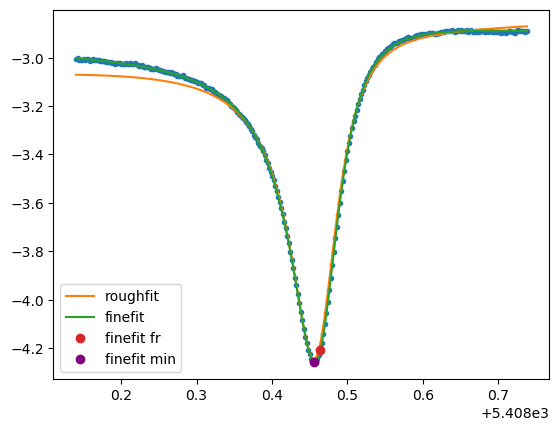

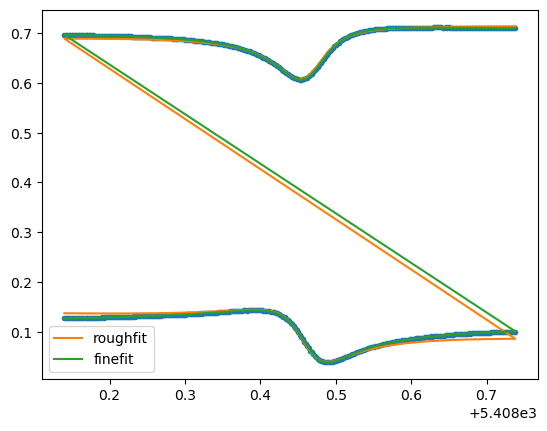

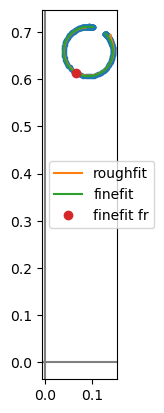

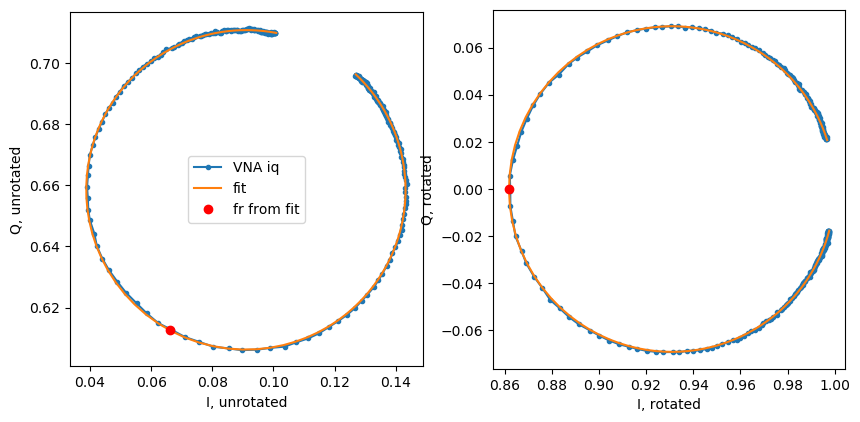

In [15]:
S.setup_notches(2,new_master_assignment=True, tone_power=13)
S.set_feedback_enable_channel(2,66,0) #stop feedback on resonant frequency. Just send 1 fixed tone
    
for ch in S.which_on(2):
    S.channel_off(2, ch)
## 2.3 vpp
fit_dict, fit_errs = fit_data(S.tune_file, 2)

S.set_fixed_tone(fit_dict['f0'], 13)

1
4.166666666666667
0


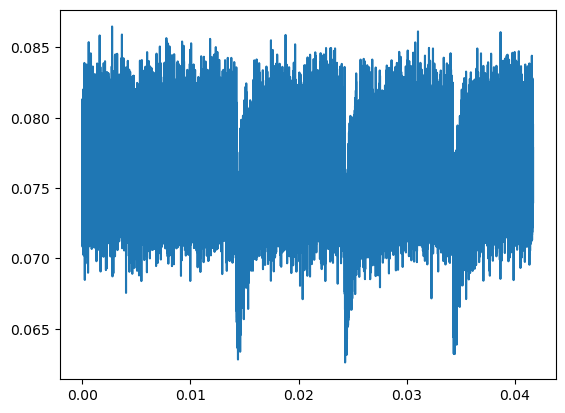

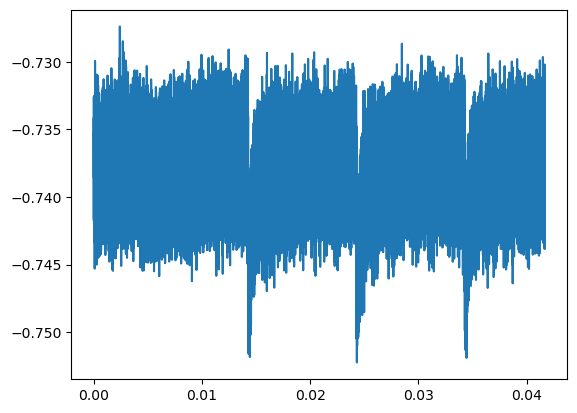

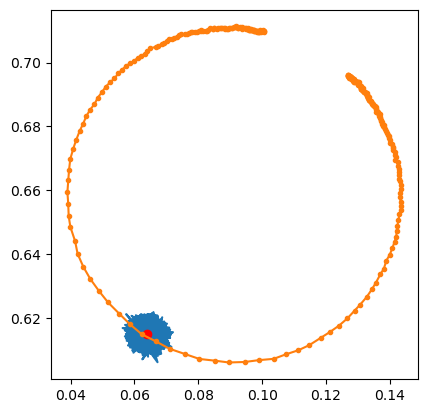

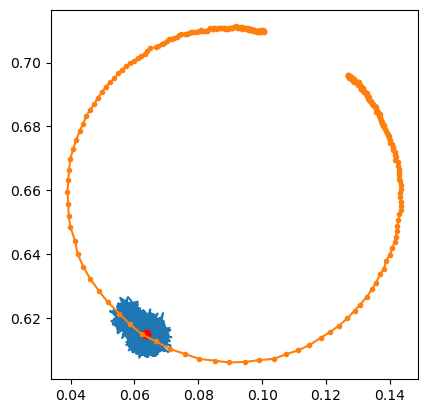

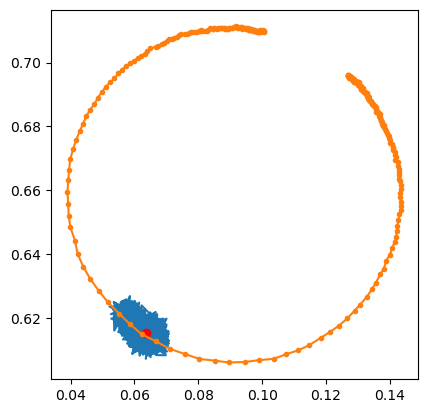

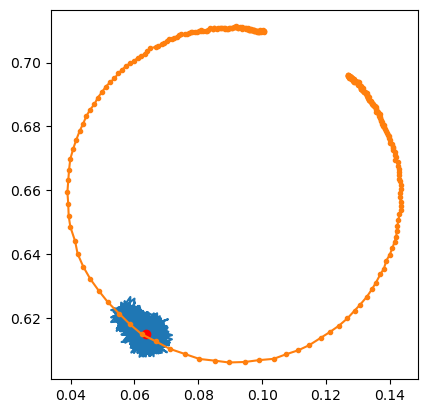

In [26]:
total_samples = 50000
## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .82')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
tune_dict=load_tune_file(S.tune_file, 2, db_offset=1)
i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()

1
4.166666666666667
0


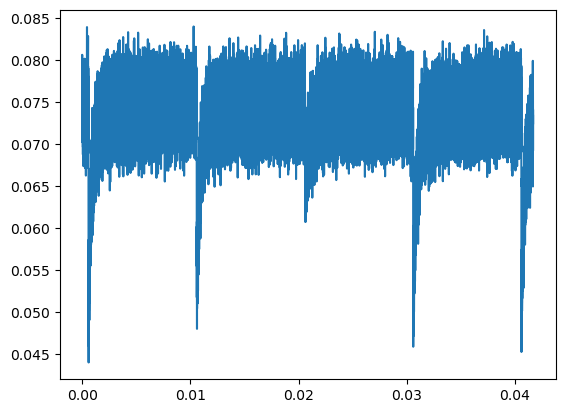

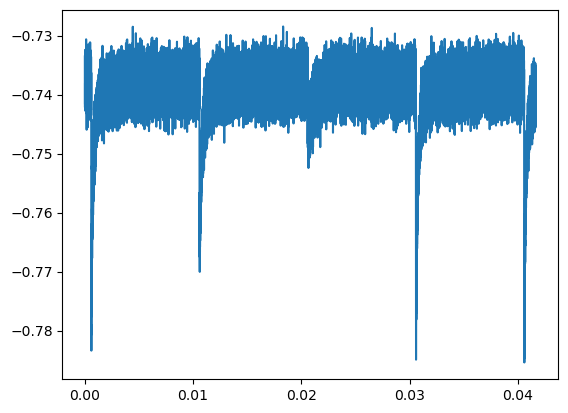

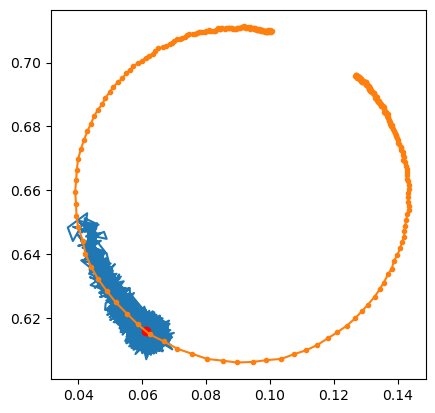

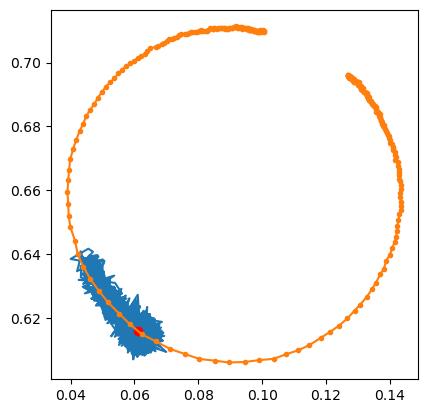

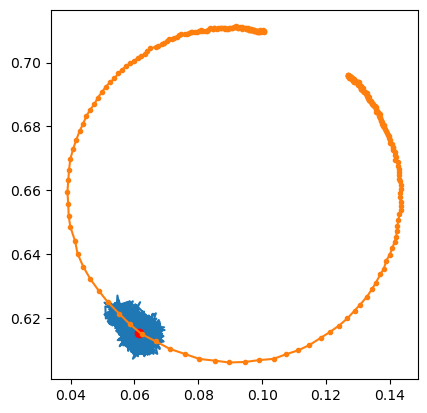

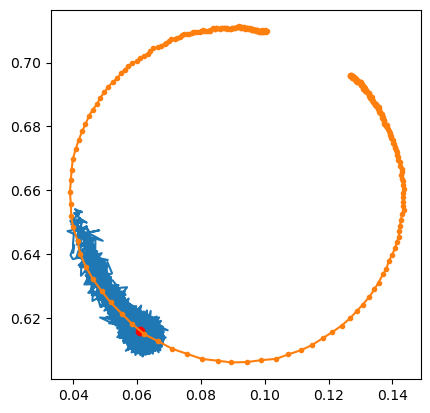

In [27]:
total_samples = 50000
## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT .83')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]
time_per_sample = (1/2.4e6) 
time_per_cycle = 1/100
n_cycles = 2

# nsamp = 2**20
nsamp= int(n_cycles * total_samples) #int(n_cycles * time_per_cycle / time_per_sample)
print(nsamp/ (time_per_cycle / time_per_sample))
timestamp = S.get_timestamp()
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(2.4e6)
plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()
tune_dict=load_tune_file(S.tune_file, 2, db_offset=1)
i_chunks = chunk_data(2.4 , 10000, i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()

Ok this is a very promising start!
still need to: 
1. fix some of the functions
2. change how we log the waveform file
3. update plotting for big data run
4. change how we loop through waveforms. 

In [40]:
from instr_control.awg_control import send_command, query_instrument

In [ ]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
WVFM_DURATION_S = 50e-3  # 50 ms total duration
WVFM_SAMP_RATE_HZ = wvfm_sampxles / wvfm_duration_s 
VOLT = 0.81
FREQ = 1/wvfm_duration_s #HZ

PULSE_DURATION_US = [10 , 10, 10, 10, 10] # Duration of each square wave in microseconds
AMPLITUDES = [1, .999, .998, .995, .985]  # Example amplitudes for the 5 segments

N_CYCLES = 2
SMURF_SAMP_RATE_HZ = 2.4e6

# Convert the waveform data to a comma-separated string
waveform_string = create_waveform(PULSE_DURATION_US, AMPLITUDES, WVFM_SAMP_RATE_HZ, WVFM_DURATION_S, dac_max=2047, plot=True)


input("enter to download.")
#### DOWNLOAD TO AWG 
start_time = time.time()
send_command(awg, 'DATA:DEL')
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")


## send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,f'FREQ {FREQ}')  # Set frequency to 500 Hz
send_command(awg,f'VOLT {VOLT}')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output
sleep(30)
query_instrument(awg, 'OUTP?')
# repeatin 10us 1V (2V on oscope?) pulses 
band=2
channel=S.which_on(band)[0]


# nsamp = 2**20
nsamp = int(N_CYCLES * WVFM_DURATION_S * SMURF_SAMP_RATE_HZ) 

timestamp = S.get_timestamp() 
filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
i,q,sync = S.take_debug_data(band=band,channel=channel,
                              rf_iq=True,nsamp=nsamp,
                              filename = filename)   

send_command(awg,'OUTP OFF')  # Enable the output
query_instrument(awg, 'OUTP?')

time_arr = np.arange(len(i))/(SMURF_SAMP_RATE_HZ)

plt.plot(time_arr, i)
plt.ylim()
plt.show()
plt.plot(time_arr, q)
plt.show()

i_chunks = chunk_data(2.4 , int(wvfm_samples/num_pulses), i/(1.2), start=0)
q_chunks = chunk_data(2.4 , 10000, q/(-1.2), start=0)
for chunk in range(len(i_chunks)):
    plt.plot(i_chunks[chunk], q_chunks[chunk])
    plt.plot(np.mean(i_chunks[chunk]), np.mean(q_chunks[chunk]), 'ro')
    plt.plot(tune_dict['r'].real, tune_dict['r'].imag, marker='.')
    plt.gca().set_aspect('equal')
    plt.show()


In [44]:
wvfm_duration_s = 50e-3  # 50 ms total duration
wvfm_samples = 50000
sampling_rate = wvfm_samples / wvfm_duration_s #  int(sampling_rate * wvfm_duration_ms / 1000)  # Total samples = 5000
print(sampling_rate/1e6)

1.0


In [45]:
1/1e6

1e-06

In [19]:
import numpy as np
def create_waveform(pulse_durations_us, amplitudes, wvfm_samp_rate_Hz, wvfm_duration_s, dac_max=2047, plot=True):
    # pulse_durations_us and amplitudes must be iterable, with same length = num_pulses
    num_pulses = len(pulse_durations_us)
    if num_pulses != len(amplitudes):
        print(num_pulses)
        print(len(amplitudes))
        return "pulse_durations_us and amplitudes must have same length"
    
    segment_duration_s = (wvfm_duration_s / num_pulses) 
    segment_samples = int(wvfm_samp_rate_Hz * segment_duration_s)  # Samples per segment
    print(f"segment_samples = {segment_samples}")
    print(f"segment duration (s)  = {segment_duration_s}")
    # Create the arbitrary waveform data
    waveform_data = []

    for idx in range(num_pulses):
        amplitude = amplitudes[idx]
        t_us = pulse_durations_us[idx]
        # Calculate the number of points for each square wave (high and low) given t_us
        t_samples = int(wvfm_samp_rate_Hz * (t_us * 1e-6))  # Convert t in microseconds to number of samples
        print(f't_samples ={t_samples}')
        dac_amplitude = int(dac_max * amplitude)
        # Create one segment with alternating high and low values
        high_segment = [dac_amplitude] * t_samples  # High segment for duration t
        low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

        # Combine to form a complete segment
        segment = high_segment + low_segment
        segment = segment[:segment_samples]  # Ensure the segment is the correct length
        # Add the segment to the overall waveform
        waveform_data.extend(segment)

    # Ensure total waveform length 
    #waveform_data = waveform_data[:wvfm_samples] + [0] * (wvfm_samples - len(waveform_data))

    # Convert the waveform data to a comma-separated string
    waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)
    if plot == True: 
        print(np.shape(t_samples))
    plt.plot(np.arange(len(waveform_data))/wvfm_samp_rate_Hz, waveform_data, 'C0.-')
    plt.xlabel("time (s)")
    plt.ylabel("DAC")
    plt.show()

    return waveform_string


segment_samples = 500000
segment duration (s)  = 0.5
t_samples =99999
t_samples =199999
()


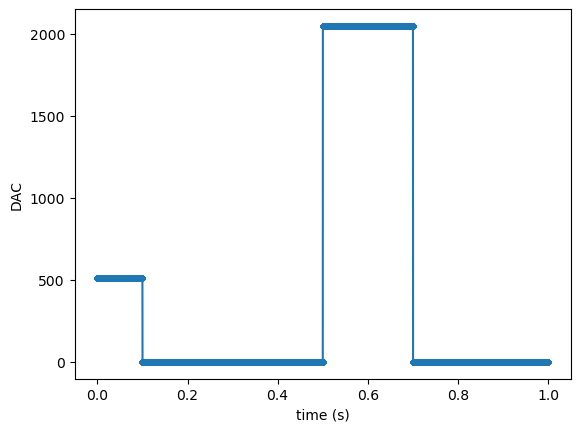

In [32]:
wvfm = create_waveform([.1e6, .2e6], [.25, 1], 1e6, 1, dac_max=2047, plot=True)

In [31]:
0.1e6*1e-6  * 1e6


99999.99999999999

In [33]:

1 / 50e-3 

20.0

In [35]:
print(S.which_on(2))

NameError: name 'S' is not defined